# In this Jupyter Notebook I will analyse the data from the non-coding RNA screen and the bioneer screen.

In [125]:
#importing the packages used
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import scipy.stats as stats
import pandas as pd
from skimage.morphology import square
from skimage.measure import label, regionprops
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from matplotlib.axes import Axes
from skimage.filters import threshold_otsu
import skimage.io
import skimage.filters
import skimage.measure
import os

#Show the actual image from an image matrix
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')

#To read an image:
def read_image(filename):
    image = plt.imread(filename)

#set directory
base_dir = os.path.normpath("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/google drive data/scanner/")

#Make crop function
def crop(image):
    #take first and last 50 rows and columns
    image=np.delete(image,range(len(image)-50,len(image)),0)
    image=np.delete(image,range(0,50),0)
    image=np.delete(image,range(len(image[0])-50,len(image[0])),1)
    image=np.delete(image,range(0,50),1)
    return image

#Define each colony as a distinct "object"
def connected_components(filename, connectivity=2):
    # load the image
    image = skimage.io.imread(filename)
    #Crop the image
    image=crop(image)
    #blur the image
    image = skimage.filters.gaussian(image, sigma=7, truncate=8, channel_axis=True)
    # make an inverted binary
    thresh = threshold_otsu(image)
    binary = image > thresh
    binary_mask=np.invert(binary)
    #Set the minimum area of an object to 2 pixels (python was picking up 1-pixel objects when I first tried it)

    #mask is the binary mask from which objects were found (a matrix of 1s and 0s)
    mask = skimage.morphology.remove_small_objects(binary_mask,1000)
    # perform connected component analysis (count=number of objects)

    #count is the number of objects there are (numbered 1-96 if there are 96 objects)
    #labeled_image is a matrix where each object is numbered 1-96 (the background is 0)
    labeled_image, count = skimage.measure.label(mask,connectivity=connectivity, return_num=True)

    #regions group the individual object properties
    regions=regionprops(labeled_image)
    return labeled_image, count, regions, mask




#Find and label objects in the original JB50 7x7 plate

baseline_fname = "/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/google drive data/scanner/20220627_biofilm_JB50_7x7/20220627_1_biofilm_JB50_7x7.jpg"
labeled_image,count,regions,mask=connected_components(baseline_fname)

#Name each object after its position (A1-H12)
def number_plate(regions):
  x_array=[]
  y_array=[]
  for r in regions:
    x,y=r["centroid"]
    x_array.append(x)
    y_array.append(y)
  rows=pd.cut(x_array,8, labels=["A","B","C","D","E","F","G","H"])
  cols=pd.cut(y_array,12, labels=["1","2","3","4","5","6","7","8","9","10","11","12"])
  index=[]
  for i in range(0,len(rows)):
    index.append(rows[i]+cols[i])
  d = {'x': x_array, 'y': y_array, "row": rows, "col":cols, "index": index}
  df = pd.DataFrame(data=d)
  return df

#Show the dataframe of x (vertical) and y (horizontal) coordinates of the centroid of each object
df=number_plate(regions)

m=np.zeros((len(mask),len(mask[0])))

for ind in df["index"]:
  i=df[df['index']==ind].index[0]
  r=df[df["row"]==df.iat[i,2]]
  c=df[df["col"]==df.iat[i,3]]
  x=st.mean([df.iat[r[r["col"]=="12"].index[0],0],df.iat[r[r["col"]=="1"].index[0],0]])
  y=st.mean([df.iat[c[c["row"]=="A"].index[0],1],df.iat[c[c["row"]=="H"].index[0],1]])
  minr=int(round(x-45))
  minc=int(round(y-45))
  maxr=int(round(x+45))
  maxc=int(round(y+45))
  m[minr:maxr,minc:maxc]=square(90)

#Find and label objects in the new binary
labeled_image, count = skimage.measure.label(m,connectivity=2, return_num=True)
regions=regionprops(labeled_image)

#Return a dataframe of x and y coordinates of object centroids
df=number_plate(regions)

#Make a dictionary of each plate number
plate={}
n=0
for r in range(0,len(regions)):
  n=df.iat[r,2]+df.iat[r,3]
  plate[n]=regions[r]

#Create an array of median intensity for each square for "image" from "labeled_image"
def median_int(image,labeled_image,plate,median=True):
    mi=[]
    
    for i in plate.keys():
        m=np.median(image[np.where(labeled_image==plate[i]["label"])])
        if median == False:
            m=np.mean(image[np.where(labeled_image==plate[i]["label"])])
        mi.append(m)
    maxval=np.max(image)
    return mi, maxval 

#Make a dataframe with all info for each strain and only keep segregants and B2 (759) and C2 (JB50)
def processing(image,image_w,rep,plate,strain_layout,labeled_image_,median=True):
    median_intensities,max_val = median_int(image, labeled_image_,plate)
    median_intensities_w, max_val_w = median_int(image_w, labeled_image_,plate)
    if median == False:
        median_intensities,max_val = median_int(image, labeled_image_,plate,median=False)
        median_intensities_w, max_val_w = median_int(image_w, labeled_image_,plate,median=False)
    
    before_vals = median_intensities/max_val
    before_vals = before_vals - np.min(before_vals)

    after_vals = median_intensities_w/max_val_w
    after_vals = after_vals- np.min(after_vals)

    d = {"rep":rep,
        'position': dict.keys(plate),
         "x_coord":[plate[i]["centroid"][1] for i in dict.keys(plate)],
         "y_coord":[plate[i]["centroid"][0] for i in dict.keys(plate)],
         "strain":strain_layout,
         'before_wash': before_vals,
         "after_wash": after_vals
        }
    
    df = pd.DataFrame(data=d)
    df["ratio"]=df["after_wash"]/df["before_wash"]
    
    #for position, put a _ after the letter and the number like "B_1_"
    df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
    #add a _ to the end of position entries
    df["position"]=df["position"]+"_"
    

    #df_seg=df.loc[df['strain'].isin(map_names)]
    #df_seg=pd.concat([df.loc[df['position'] == "B2"],df.loc[df['position'] == "C2"],df_seg])
    return df

#Import images
def import_im(directory):
  image_1=np.invert(crop(skimage.io.imread(directory)))
  return image_1


def layout_from_map(map_filename):
      strains=pd.DataFrame.transpose(map_filename)
      strain_layout2=[]
      for i in range(0,8): #get strains in each of 8 columns
            strain_layout2.extend(strains[i])
      return strain_layout2

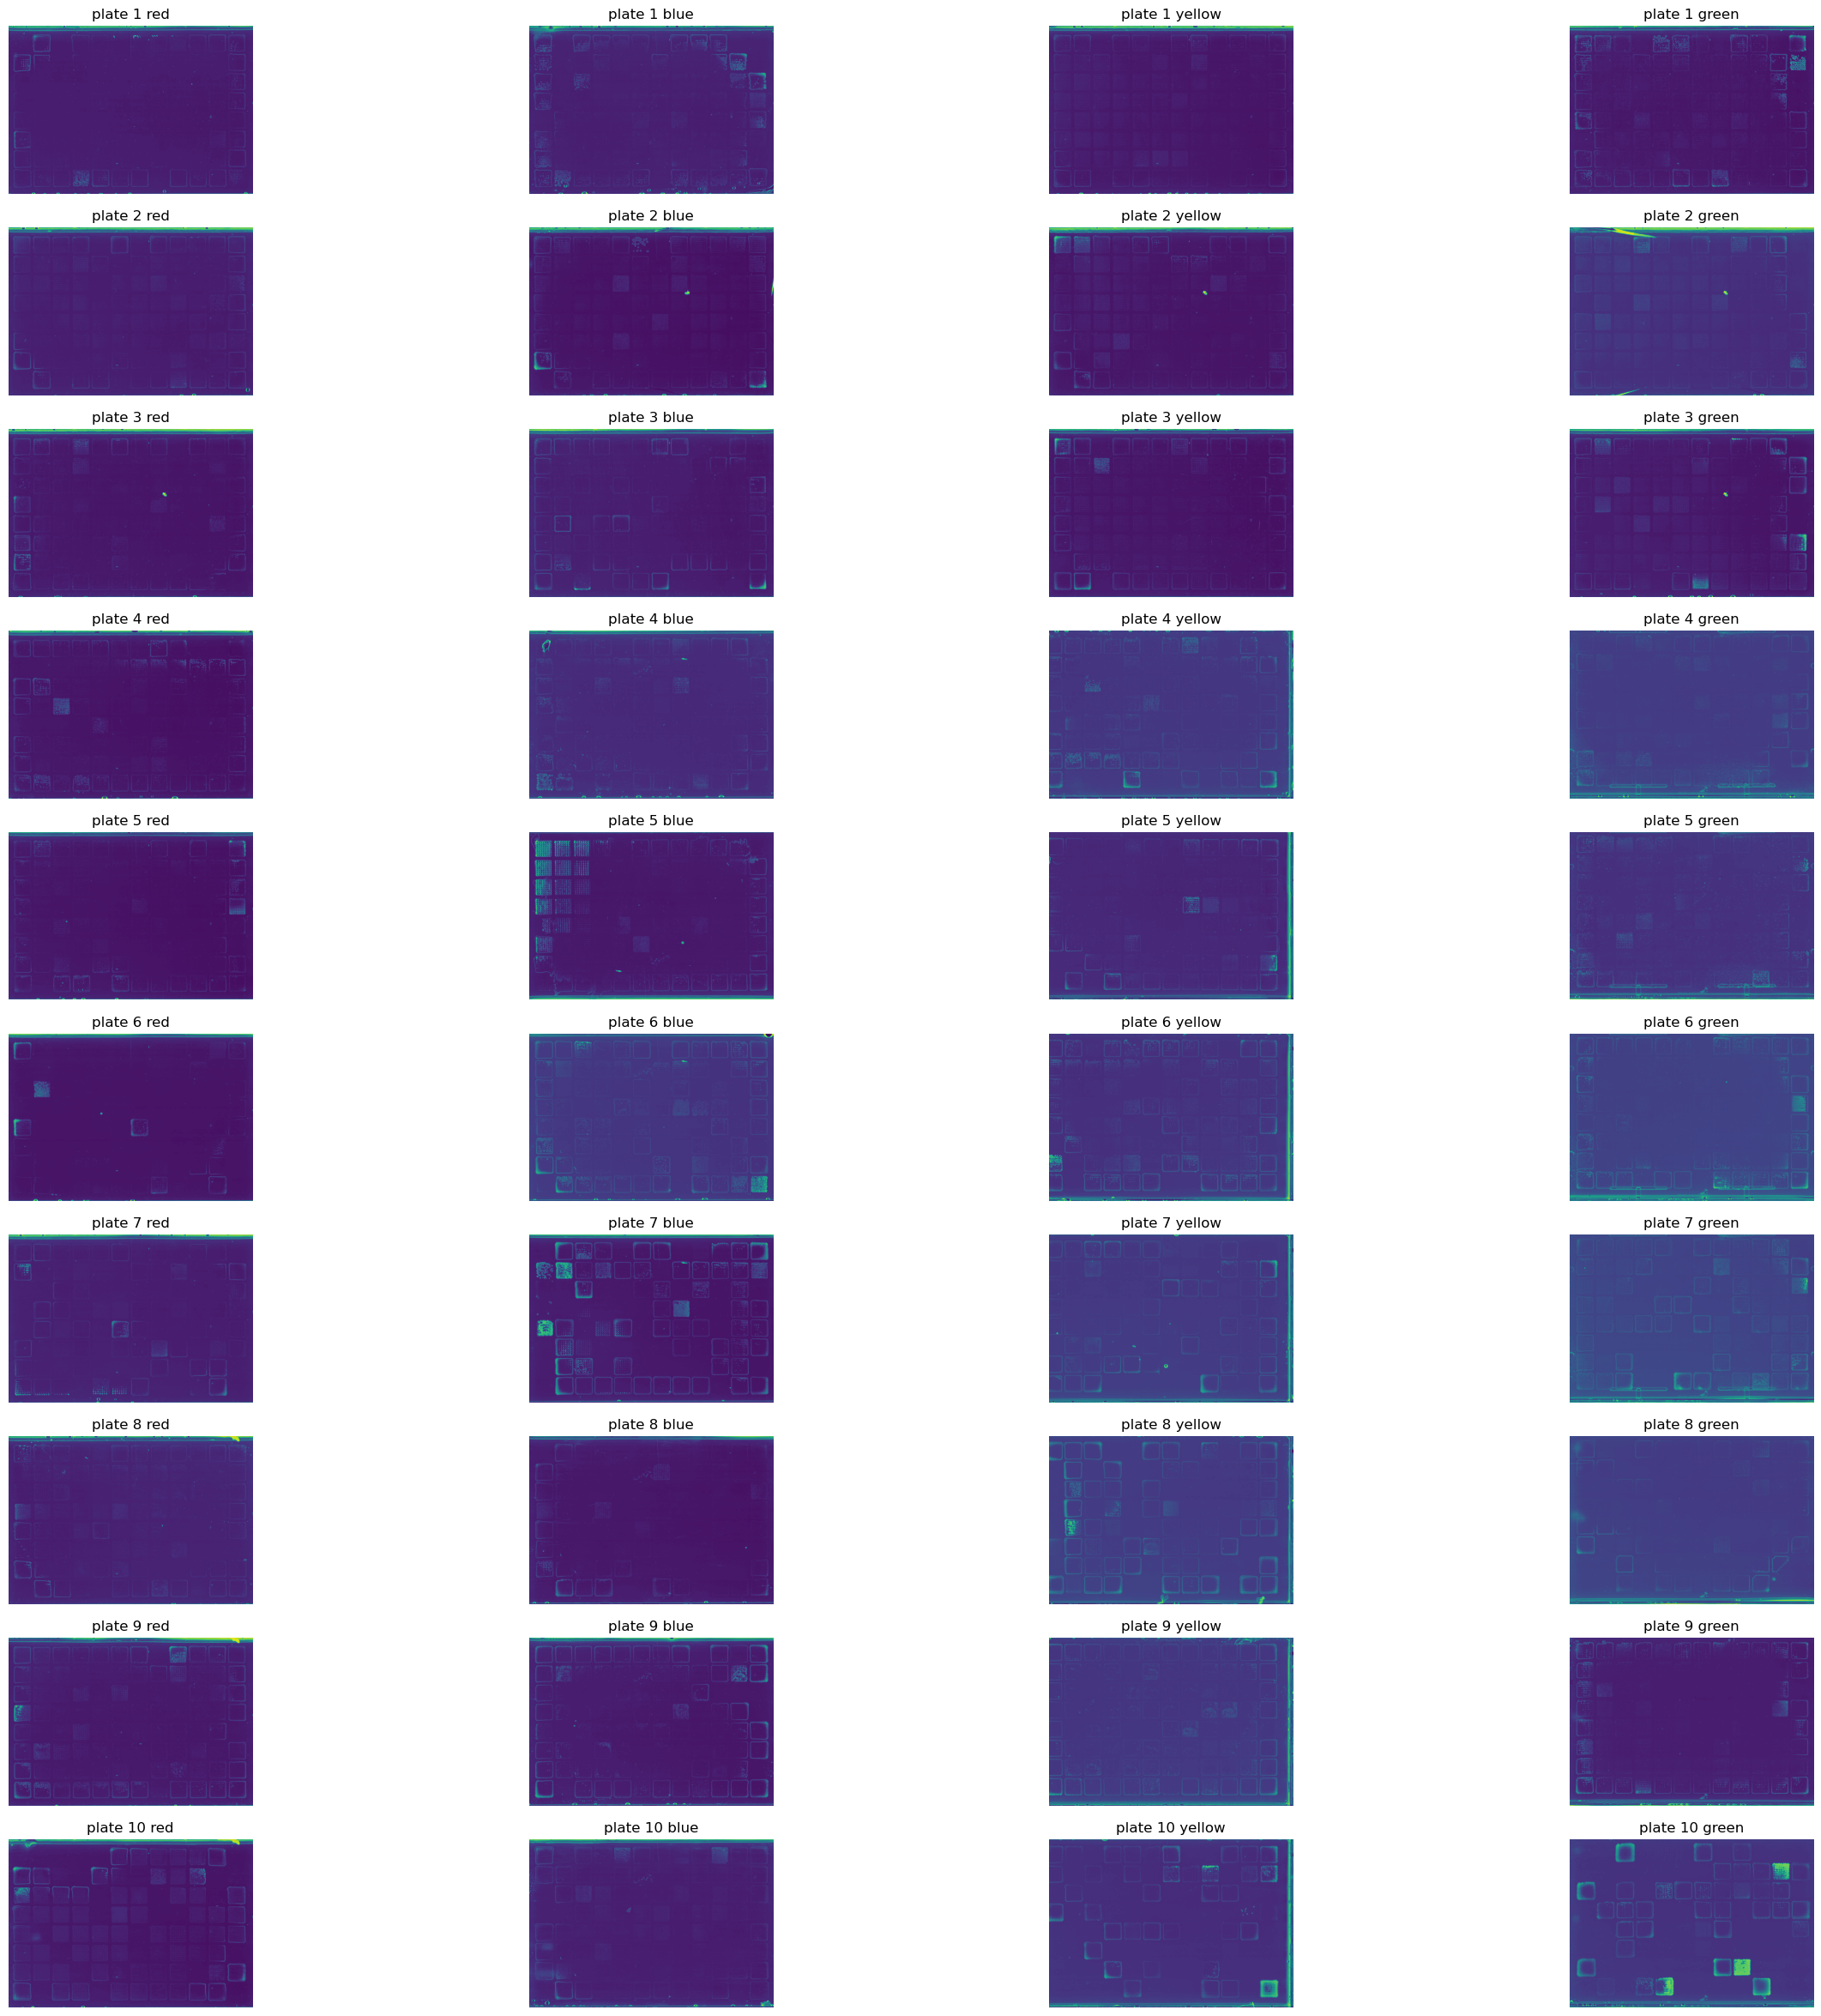

In [126]:
#iterate through every single num and col file and show image below
plots = []
for num in range(1,11):
      for color in ["red","blue","yellow","green"]:
            #create layout
            image_w=import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/bioneer screen/images/20230227_1_biofilm_bioneer_p"+str(num)+"_"+color+"_w.jpg")
            plots.append(image_w)
            #create layout
#create lots of plots   
fig, axs = plt.subplots(10, 4, figsize=(30, 30))
for i in range(0,10):
      for j in range(0,4):
            axs[i,j].imshow(plots[i*4+j])
            axs[i,j].set_title("plate "+str(i+1)+" "+["red","blue","yellow","green"][j])
            axs[i,j].axis('off')

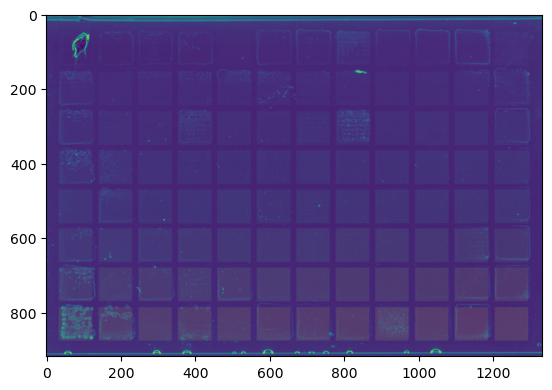

In [127]:

labeled_im_1=np.zeros((len(labeled_image),len(labeled_image[0])))
labeled_im_1[:,:-30]=labeled_image[:,30:]
#do overlay of labeled_image with plots 1
plt.imshow(plots[13])
plt.imshow(labeled_im_1,alpha=0.1)



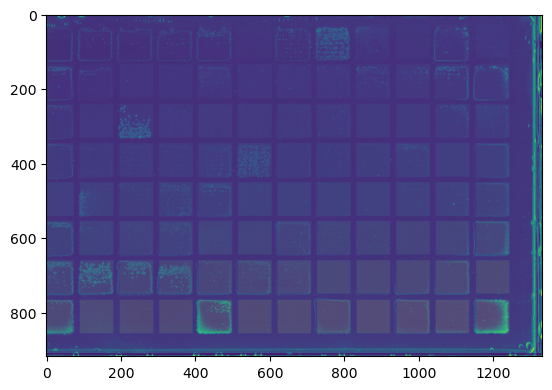

In [128]:

labeled_im_2=np.zeros((len(labeled_image),len(labeled_image[0])))
labeled_im_2[:-20,:-80]=labeled_image[20:,80:]
#do overlay of labeled_image with plots 1
plt.imshow(plots[14])
plt.imshow(labeled_im_2,alpha=0.1)


This shows we have to change the grid for plate 4,5,6,7 yellow


In [129]:
# /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/bioneer screen/images/20230227_1_biofilm_bioneer_p1_blue_w.jpg
# /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/bioneer/1_red.csv
# /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/bioneer/384_well_layout_plate_1.csv

# loop through red, blue, yellow, green on the one hand, and 1,1,1,1,2,2,2,2 on the other
# for each combination, import the image, and then run the processing function and save as a variable
#create results dataframe with columns gene, position, ratio
results = pd.DataFrame(columns = ['gene', "before_wash",'plate','color', 'position', 'ratio'])
for num in range(1,11):
    for color in ["red","blue","yellow","green"]:
        #create layout
        map = pd.read_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/bioneer/96_well_layout_plate_"+str(num)+"_"+color+".csv",header=None)
        layout=layout_from_map(map)
        image=import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/bioneer screen/images/20230227_1_biofilm_bioneer_p"+str(num)+"_"+color+".jpg")
        image_w=import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/bioneer screen/images/20230227_1_biofilm_bioneer_p"+str(num)+"_"+color+"_w.jpg")
        
        df=processing(image,image_w,num,plate,layout,labeled_im_1)
        
        if color=="yellow" and num in [4,5,6,7,8,9,10]:
            df=processing(image,image_w,num,plate,layout,labeled_im_2)
        #from df append the rep, position, gene and ratio to results
        #in df rename rep to plate
        df.rename(columns={"rep":"plate"}, inplace=True)
        #rename strain to gene
        df.rename(columns={"strain":"gene"}, inplace=True)
        
       
        #keep top 5 highest ratio values
        
        df["color"] = color
        results = results.append(df[['gene',"before_wash", 'plate','color', 'position', 'ratio']], ignore_index=True)

results_mean = pd.DataFrame(columns = ['gene', "before_wash",'plate','color', 'position', 'ratio'])
for num in range(1,11):
    for color in ["red","blue","yellow","green"]:
        #create layout
        map = pd.read_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/bioneer/96_well_layout_plate_"+str(num)+"_"+color+".csv", header=None)
        layout=layout_from_map(map)
        image=import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/bioneer screen/images/20230227_1_biofilm_bioneer_p"+str(num)+"_"+color+".jpg")
        image_w=import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/bioneer screen/images/20230227_1_biofilm_bioneer_p"+str(num)+"_"+color+"_w.jpg")
        df=processing(image,image_w,num,plate,layout,labeled_im_1,False)
        
        if color=="yellow" and num in [4,5,6,7,8,9,10]:
            df=processing(image,image_w,num,plate,layout,labeled_im_2,False)
        #from df append the rep, position, gene and ratio to results
        #in df rename rep to plate
        df.rename(columns={"rep":"plate"}, inplace=True)
        #rename strain to gene
        df.rename(columns={"strain":"gene"}, inplace=True)
      
       
        df["color"] = color
        results_mean = results_mean.append(df[['gene', "before_wash",'plate','color', 'position', 'ratio']], ignore_index=True)
#remove NaNs
results = results.dropna()
results_mean = results_mean.dropna()
        

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/1896631122.py:161: FutureWarning: The default value of regex will change from True to False in a future version.
  df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/1667128846.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(df[['gene',"before_wash", 'plate','color', 'position', 'ratio']], ignore_index=True)
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/1896631122.py:161: FutureWarning: The default value of regex will change from True to False in a future version.
  df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/1667128846.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

# Loading in the ncRNA results

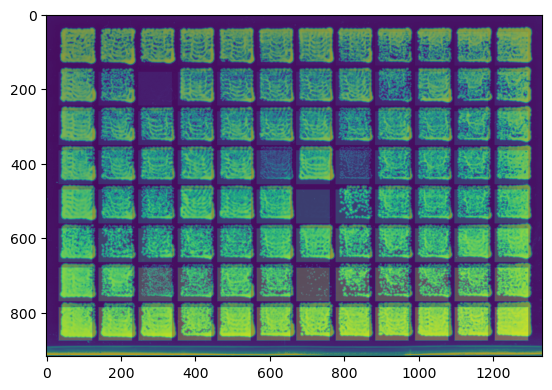

In [130]:
color = "blue"
num=2
image=import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/ncRNA_adhesion/images/20230220_1_biofilm_ncrna_del_emm_plate_"+str(num)+"_"+color+".jpg")
image_w=import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/ncRNA_adhesion/images/20230220_1_biofilm_ncrna_del_emm_plate_"+str(num)+"_"+color+"_w.jpg")
#turn image 180 degrees
image = np.rot90(image,2)
plt.imshow(image)
plt.imshow(labeled_im_1, alpha=0.3)

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/1896631122.py:161: FutureWarning: The default value of regex will change from True to False in a future version.
  df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/2031118587.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_ncrna = results_ncrna.append(df[['gene',"before_wash", 'plate','color', 'position', 'ratio']], ignore_index=True)
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/1896631122.py:161: FutureWarning: The default value of regex will change from True to False in a future version.
  df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/2031118587.py:32: FutureWarning: The frame.append method is deprecated and will be removed from p

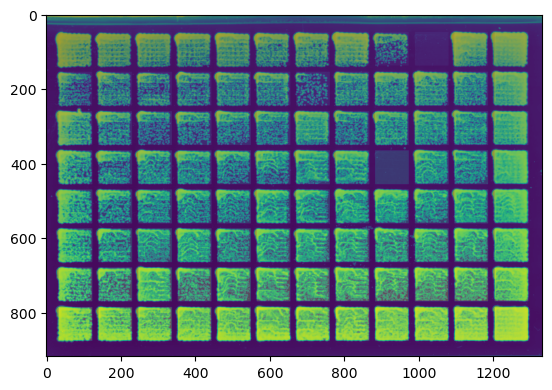

In [131]:
results_ncrna = pd.DataFrame(columns = ['gene', "before_wash",'plate','color', 'position', 'ratio'])
for num in range(1,3):
    for color in ["red","blue","yellow","green"]:
        #create layout
        map = pd.read_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Rodriguez-Lopez et al. ncRNA deletion library/ncRNA_"+color+"_plate_" + str(num) + ".csv",header=0)
        layout=layout_from_map(map)
        if color=="yellow" and num==2:
            color="yellow_rev"
        
        image=import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/ncRNA_adhesion/images/20230220_1_biofilm_ncrna_del_emm_plate_"+str(num)+"_"+color+".jpg")
        image_w=import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/ncRNA_adhesion/images/20230220_1_biofilm_ncrna_del_emm_plate_"+str(num)+"_"+color+"_w.jpg")
        plt.imshow(image)
        plt.imshow(labeled_im_1, alpha=0.3)
        df=processing(image,image_w,num,plate,layout,labeled_im_1)
        
        if color=="yellow" and num==2:

            #flip uspide down
            np.rot90(image,2)
            np.rot90(image_w,2)
            df=processing(image,image_w,num,plate,layout,labeled_im_2)
        #from df append the rep, position, gene and ratio to results
        #in df rename rep to plate
        df.rename(columns={"rep":"plate"}, inplace=True)
        #rename strain to gene
        df.rename(columns={"strain":"gene"}, inplace=True)
        
       
        #keep top 5 highest ratio values
        
        df["color"] = color
        results_ncrna = results_ncrna.append(df[['gene',"before_wash", 'plate','color', 'position', 'ratio']], ignore_index=True)

In [132]:
#sort results by ratio
results_ncrna.sort_values(by=['ratio'], ascending=False, inplace=True)
#show where gene contans 781
#turn gene into str
results_ncrna["gene"] = results_ncrna["gene"].astype(str)
#remove entries where gene contains 972	
results_ncrna = results_ncrna[~results_ncrna["gene"].str.contains("972")]
#concat results_ncrna and results
#but make a new column for the source of the data
results_ncrna["source"] = "ncRNA"
results["source"] = "bioneer"
results = pd.concat([results,results_ncrna], ignore_index=True)
results

gene  before_wash plate       color position     ratio   source
0           empty     0.025381     1         red     A_1_  0.784080  bioneer
1     SPAC1002.20     0.680203     1         red     A_2_  0.036571  bioneer
2     SPAC11E3.06     0.015228     1         red     A_3_  0.980100  bioneer
3     SPAC11E3.10     0.624365     1         red     A_4_  0.023905  bioneer
4     SPAC11E3.12     0.609137     1         red     A_5_  0.032670  bioneer
...           ...          ...   ...         ...      ...       ...      ...
4106      177.3-2     0.515625     2  yellow_rev    F_11_  0.000000    ncRNA
4107     1443.3-2     0.505208     2  yellow_rev    G_10_  0.000000    ncRNA
4108     1278:hyg     0.319249     1      yellow    G_10_  0.000000    ncRNA
4109      414.3-1     0.089744     1        blue     C_5_  0.000000    ncRNA
4110        cds1D     0.000000     1      yellow    G_12_       NaN    ncRNA

[4111 rows x 7 columns]

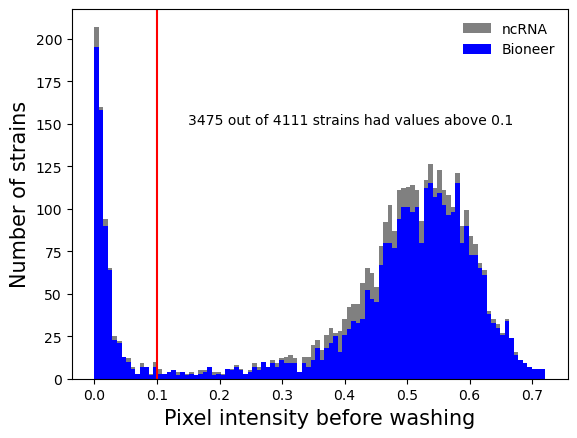

In [133]:

plt.hist(results["before_wash"], bins=100, color="grey")
#color entries that are bioneer
plt.hist(results[results["source"]=="bioneer"]["before_wash"], bins=100, color="blue")

#and write the number of values that made the cute and didnt make the cut

plt.text(0.15, 150, str(str(len(results[results["before_wash"]>=0.1])) + " out of " + str(len(results)) + " strains had values above 0.1"))
plt.xlabel("Pixel intensity before washing", fontsize=15)
plt.ylabel("Number of strains", fontsize=15)
#add legend showing that red is bioneer and blue is ncRNA with a thin line

plt.legend(["ncRNA","Bioneer"], loc="upper right", frameon=False)

#draw a red line at 0.1
plt.axvline(x=0.1, color='r', linestyle='-')


plt.show()

In [134]:
#results plate 7 color blue
results.loc[(results["plate"]==7) & (results["color"]=="blue")].sort_values(by=['ratio'], ascending=False).head(20)


gene  before_wash plate color position     ratio   source
2471   SPAC23H4.17c     0.000000     7  blue    G_12_       inf  bioneer
2445     SPAC4H3.06     0.000000     7  blue    E_10_       inf  bioneer
2468     SPAC227.15     0.004484     7  blue     G_9_  3.000000  bioneer
2467    SPAC20H4.09     0.008969     7  blue     G_8_  2.000000  bioneer
2456     SPCC757.12     0.004484     7  blue     F_9_  2.000000  bioneer
2481     SPAC6G9.08     0.008969     7  blue    H_10_  1.500000  bioneer
2454     SPBC713.09     0.008969     7  blue     F_7_  1.500000  bioneer
2463  SPAC13A11.01c     0.017937     7  blue     G_4_  1.500000  bioneer
2451    SPBC19G7.02     0.022422     7  blue     F_4_  1.400000  bioneer
2453    SPBC651.12c     0.013453     7  blue     F_6_  1.333333  bioneer
2416   SPAC3A12.13c     0.013453     7  blue     C_5_  1.333333  bioneer
2392   SPBC18H10.14     0.013453     7  blue     A_5_  1.333333  bioneer
2466    SPAC19D5.03     0.013453     7  blue     G_7_  1.333333  bioneer
2465    SPAC19D5.01     0.013453     7  blue     G_6_  1.333333  bioneer
2425   SPAC22H12.02     0.017937     7  blue     D_2_  1.250000  bioneer
2413          empty     0.017937     7  blue     C_2_  1.250000  bioneer
2388    SPAC7D4.06c     0.017937     7  blue     A_1_  1.250000  bioneer
2452     SPBC3D6.05     0.017937     7  blue     F_5_  1.250000  bioneer
2460   SPAC1071.04c     0.022422     7  blue     G_1_  1.200000  bioneer
2424    SPBC365.14c     0.022422     7  blue     D_1_  1.200000  bioneer

In [135]:
#From both results and results_mean remove entries with before_wash < 0.1
results = results.loc[results["before_wash"] > 0.1]
results_mean = results_mean.loc[results_mean["before_wash"] > 0.1]


In [136]:

print("Number of entries kept: ", len(results))
print("Number of entries kept: ", len(results_mean))

Number of entries kept:  3475
Number of entries kept:  3060


In [137]:
#remove genes from ncrna
results = results[results["source"]=="bioneer"]

In [138]:
#add a column called ecdf to results
results["ecdf"] = 0
#sort results by ratio
results.sort_values(by=['ratio'], ascending=False, inplace=True)
#reset
results.reset_index(drop=True, inplace=True)
#ecdf should be the fraction of entries that have a ratio lower than the current entry

results["ecdf"] = 1-np.arange(len(results))/len(results)
results


gene  before_wash plate   color position     ratio   source  \
0      SPAC23H3.03c     0.157609     1   green    B_12_  0.819837  bioneer   
1       SPAC26F1.03     0.578475     7    blue     E_1_  0.759690  bioneer   
2       SPBC2G2.13c     0.529148     7    blue     B_2_  0.644068  bioneer   
3       SPAC13D6.01     0.431111     5    blue     A_1_  0.629752  bioneer   
4        SPAC959.08     0.251185     6     red     C_2_  0.577264  bioneer   
...             ...          ...   ...     ...      ...       ...      ...   
3017  SPAC30D11.06c     0.469194     6     red     F_3_  0.000000  bioneer   
3018    SPAC26A3.02     0.516588     6     red     F_2_  0.000000  bioneer   
3019   SPAC5H10.02c     0.504762     5     red     E_9_  0.000000  bioneer   
3020   SPAC22H10.08     0.620853     6     red    E_12_  0.000000  bioneer   
3021  SPBC32F12.07c     0.513393     7  yellow     B_6_  0.000000  bioneer   

          ecdf  
0     1.000000  
1     0.999669  
2     0.999338  
3     0.999007  
4     0.998676  
...        ...  
3017  0.001655  
3018  0.001324  
3019  0.000993  
3020  0.000662  
3021  0.000331  

[3022 rows x 8 columns]

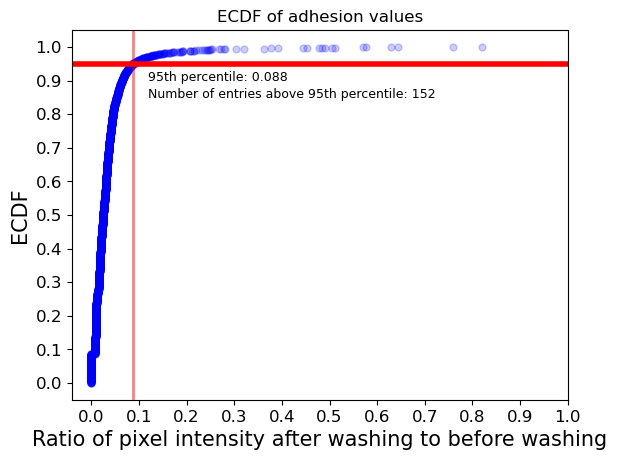

In [139]:
#create a plot where x is ratio and y is ecdf
#choose blue colorpalette
#dont use seaborn grid

plt.scatter(results["ratio"], results["ecdf"],  s=25,alpha=0.2, color="blue")
#add a line at 0.95
plt.axhline(y=0.95, color='r', linestyle='-',lw=4)
#make pretty
plt.xlabel("Ratio of pixel intensity after washing to before washing", fontsize=15)
plt.ylabel("ECDF", fontsize=15)
plt.title("ECDF of adhesion values", fontsize=12)
#also where the 0.95 line intersects the data, draw a vertical line
#find 95th percentile
percentile = np.percentile(results["ratio"], 95)
#draw a vertical line at that point
plt.axvline(x=percentile, color='r', linestyle='-',lw=2, alpha=0.5)
#add text to show where the line is
plt.text(0.12, 0.9, "95th percentile: " + str(round(percentile,3)), fontsize=9, color="black")
#add text to show how many entries are above the line
plt.text(0.12, 0.85, "Number of entries above 95th percentile: " + str(len(results[results["ratio"]>percentile])), fontsize=9, color="black")
#more detailed axes, meaning ticks every 0.1
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
#larger ticks
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [140]:
#SHOW VALUES with gene empty in results_mean
results_mean.loc[results_mean["gene"] == "empty"]
#both of these can be traced back to direct (from other plate) and indirect (by neighbor sample) contamination!


gene  before_wash plate color position     ratio
485   empty     0.152150     2  blue     A_6_  0.341495
1649  empty     0.132489     5  blue     B_6_  0.048615

In [141]:
#sort according to ratio 
results.sort_values(by=['ratio'], inplace=True, ascending=False)
#keep top 40 values and reset index
final=results.head(60).reset_index(drop=True)
#add column saying median
final["median_or_mean"]="median"

In [142]:
#add the last three genes from results as controls to the finals df as well
final=final.append(results.tail(3).reset_index(drop=True))
#tail 3 entreis should have median_or_mean = control
#reset index
final=final.reset_index(drop=True)
final.loc[final.index[-3:], "median_or_mean"] = "control"
final


/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/1905193340.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final=final.append(results.tail(3).reset_index(drop=True))


gene  before_wash plate   color position     ratio   source  \
0    SPAC23H3.03c     0.157609     1   green    B_12_  0.819837  bioneer   
1     SPAC26F1.03     0.578475     7    blue     E_1_  0.759690  bioneer   
2     SPBC2G2.13c     0.529148     7    blue     B_2_  0.644068  bioneer   
3     SPAC13D6.01     0.431111     5    blue     A_1_  0.629752  bioneer   
4      SPAC959.08     0.251185     6     red     C_2_  0.577264  bioneer   
..            ...          ...   ...     ...      ...       ...      ...   
58    SPAC11G7.04     0.300518     4   green    E_11_  0.152642  bioneer   
59    SPCC1259.03     0.422330     2   green     A_9_  0.151634  bioneer   
60    SPCC191.09c     0.533679     4   green     D_6_  0.000000  bioneer   
61    SPAC8E11.06     0.690000     8     red     E_1_  0.000000  bioneer   
62  SPBC32F12.07c     0.513393     7  yellow     B_6_  0.000000  bioneer   

        ecdf median_or_mean  
0   1.000000         median  
1   0.999669         median  
2   0.999338         median  
3   0.999007         median  
4   0.998676         median  
..       ...            ...  
58  0.980807         median  
59  0.980477         median  
60  0.055592        control  
61  0.055261        control  
62  0.000331        control  

[63 rows x 9 columns]

In [143]:
#take top 20 mean values
results_mean.sort_values(by=['ratio'], inplace=True, ascending=False)
mean=results_mean.head(70).reset_index(drop=True)
#add column median_or_mean
mean["median_or_mean"]="mean"
#append entries to final df that are not in final gene
final=final.append(mean[~mean["gene"].isin(final["gene"])])
final=final.reset_index(drop=True)


/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/2373310031.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final=final.append(mean[~mean["gene"].isin(final["gene"])])


In [144]:
#create a column for 384 arrangement
#iterate through genes, load the respective 384 layout based on the plate column and find position of the gene in 384 layout
final["384_row"]=""
final["384_col"]=""
for i in range(0,len(final)):
      ## /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/bioneer/384_well_layout_plate_1.csv
      plate_384 = pd.read_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/bioneer/384_well_layout_plate_"+str(final["plate"][i])+".csv", header=None)
    
      final["384_row"][i]=np.where(plate_384.to_numpy()==final["gene"][i])[0]+1
      final["384_col"][i]=np.where(plate_384.to_numpy()==final["gene"][i])[1]+1

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/3910430125.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["384_row"][i]=np.where(plate_384.to_numpy()==final["gene"][i])[0]+1
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/3910430125.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["384_col"][i]=np.where(plate_384.to_numpy()==final["gene"][i])[1]+1
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/3910430125.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [145]:
#create a coord column with plate, row, col
final["coord"]=final["plate"].astype(str)+"_"+final["384_row"].astype(str)+"_"+final["384_col"].astype(str)
#import gene annotation for gene names

In [146]:
#remove gene "empty"
final=final[final["gene"]!="empty"]
#reset index
final=final.reset_index(drop=True)
final


gene  before_wash plate  color position     ratio   source  \
0    SPAC23H3.03c     0.157609     1  green    B_12_  0.819837  bioneer   
1     SPAC26F1.03     0.578475     7   blue     E_1_  0.759690  bioneer   
2     SPBC2G2.13c     0.529148     7   blue     B_2_  0.644068  bioneer   
3     SPAC13D6.01     0.431111     5   blue     A_1_  0.629752  bioneer   
4      SPAC959.08     0.251185     6    red     C_2_  0.577264  bioneer   
..            ...          ...   ...    ...      ...       ...      ...   
84  SPAPB17E12.05     0.389653     1    red     H_4_  0.221433      NaN   
85    SPCC825.04c     0.472645     7  green     H_6_  0.216120      NaN   
86   SPBC29A10.02     0.365730     9  green     F_1_  0.213744      NaN   
87    SPAC31G5.14     0.122936     7  green    G_10_  0.209858      NaN   
88   SPBC12C2.01c     0.453374     4  green     H_9_  0.209106      NaN   

        ecdf median_or_mean 384_row 384_col        coord  
0   1.000000         median     [4]    [24]   1_[4]_[24]  
1   0.999669         median     [9]     [2]    7_[9]_[2]  
2   0.999338         median     [3]     [4]    7_[3]_[4]  
3   0.999007         median     [1]     [2]    5_[1]_[2]  
4   0.998676         median     [5]     [3]    6_[5]_[3]  
..       ...            ...     ...     ...          ...  
84       NaN           mean    [15]     [7]   1_[15]_[7]  
85       NaN           mean    [16]    [12]  7_[16]_[12]  
86       NaN           mean    [12]     [2]   9_[12]_[2]  
87       NaN           mean    [14]    [20]  7_[14]_[20]  
88       NaN           mean    [16]    [18]  4_[16]_[18]  

[89 rows x 12 columns]

In [147]:
#import /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/gene_IDs_names_products.tsv
gene_names = pd.read_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/gene_IDs_names_products.tsv", sep="\t", header=None)
#keep column 0 and 2 and rename to gene and name
gene_names=gene_names[[0,2,4]]
gene_names.columns=["gene","name","function"]
#merge final and gene_names through gene
final=pd.merge(final,gene_names, on="gene")
final

gene  before_wash plate  color position     ratio   source  \
0    SPAC23H3.03c     0.157609     1  green    B_12_  0.819837  bioneer   
1     SPAC26F1.03     0.578475     7   blue     E_1_  0.759690  bioneer   
2     SPBC2G2.13c     0.529148     7   blue     B_2_  0.644068  bioneer   
3     SPAC13D6.01     0.431111     5   blue     A_1_  0.629752  bioneer   
4      SPAC959.08     0.251185     6    red     C_2_  0.577264  bioneer   
..            ...          ...   ...    ...      ...       ...      ...   
84  SPAPB17E12.05     0.389653     1    red     H_4_  0.221433      NaN   
85    SPCC825.04c     0.472645     7  green     H_6_  0.216120      NaN   
86   SPBC29A10.02     0.365730     9  green     F_1_  0.213744      NaN   
87    SPAC31G5.14     0.122936     7  green    G_10_  0.209858      NaN   
88   SPBC12C2.01c     0.453374     4  green     H_9_  0.209106      NaN   

        ecdf median_or_mean 384_row 384_col        coord     name  \
0   1.000000         median     [4]    [24]   1_[4]_[24]     npr2   
1   0.999669         median     [9]     [2]    7_[9]_[2]     pda1   
2   0.999338         median     [3]     [4]    7_[3]_[4]     dcd1   
3   0.999007         median     [1]     [2]    5_[1]_[2]    pof14   
4   0.998676         median     [5]     [3]    6_[5]_[3]  rpl2102   
..       ...            ...     ...     ...          ...      ...   
84       NaN           mean    [15]     [7]   1_[15]_[7]  rpl3703   
85       NaN           mean    [16]    [12]  7_[16]_[12]    naa40   
86       NaN           mean    [12]     [2]   9_[12]_[2]     spo5   
87       NaN           mean    [14]    [20]  7_[14]_[20]     gcv1   
88       NaN           mean    [16]    [18]  4_[16]_[18]      NaN   

                                             function  
0           GATOR1-SEACIT GTPase complex subunit Npr2  
1   pyruvate dehydrogenase e1 component alpha subu...  
2                           deoxycytidylate deaminase  
3                                 F-box protein Pof14  
4                           60S ribosomal protein L21  
..                                                ...  
84                          60S ribosomal protein L37  
85                  histone N-acetyltransferase Naa40  
86                      meiotic RNA-binding protein 1  
87                    glycine decarboxylase T subunit  
88               Schizosaccharomyces specific protein  

[89 rows x 14 columns]

In [148]:
#save final to csv
final.to_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb feb 27/new data/bioneer screen/20230227_1_biofilm_bioneer_final.csv")
#also to desktop
final.to_csv("/Users/bencekover/Desktop/20230227_1_biofilm_bioneer_final.csv")

In [149]:
#create a df called angeli which has all strains from final, that are not control
angeli = final[final["median_or_mean"]!="control"]
angeli_background=results[["gene","plate","color","position","ratio","before_wash"]].copy()
#save both as .csv
#leave for both only the gene column
angeli=angeli["gene"]
#remove index
angeli_background=angeli_background["gene"] 
angeli.to_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Angeli/bioneer_angeli.txt", index=False)
angeli_background.to_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Angeli/bioneer_angeli_background.txt", index=False)


In [150]:
#take all results where ratio is above the 95th percentile

results_above_0_05 = results[results["ratio"]>results["ratio"].quantile(0.95)]["gene"]
#save as csv
results_above_0_05.to_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Angeli/bioneer_angeli_95thpercentile.txt", index=False)
#save all results genes
results["gene"].to_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Angeli/bioneer_angeli_all_100percent.txt", index=False)

In [151]:
#load in /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/20230227_1_biofilm_bioneer_final_printed.csv
printed = pd.read_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/20230227_1_biofilm_bioneer_final_printed.csv")
#take first 53 rows
printed=printed.head(53)

In [152]:
#show final with rows where gene is not in printed and not control
final[~final["gene"].isin(printed["gene"]) & (final["median_or_mean"]!="control")]
second_print=final[~final["gene"].isin(printed["gene"]) & (final["median_or_mean"]!="control")]

In [153]:
#save
second_print.to_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/20230306_1_biofilm_bioneer_final_printed_second.csv")

Text(0.05, 0.7, 'P-value: 2e-59')

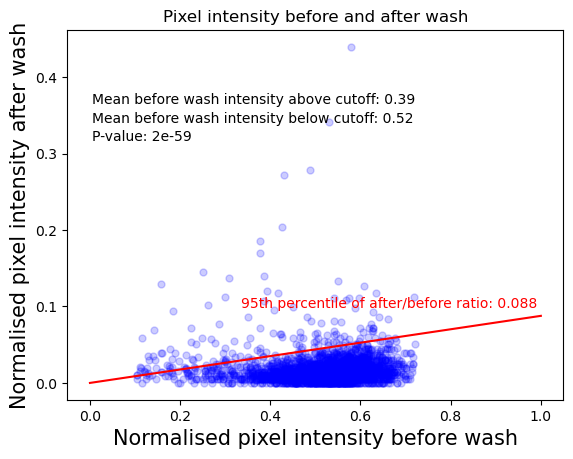

In [154]:
#create df plot_bef_aft with results but before_wash>0.1
plot_bef_aft=results[results["before_wash"]>0.1]
#plot before_wash versus before_wash*ratio and call that after_wash
plot_bef_aft["after_wash"]=plot_bef_aft["before_wash"]*plot_bef_aft["ratio"]
#also draw a line with slope of the ratio of the 95th percentile of ratio valiues
fig, ax = plt.subplots()
ax.scatter(plot_bef_aft["before_wash"],plot_bef_aft["after_wash"], s=25, alpha=0.2, color="blue")

ax.plot([0,1],[0,plot_bef_aft["ratio"].quantile(0.95)], color="red")
ax.set_xlabel("Normalised pixel intensity before wash", fontsize=15)
ax.set_ylabel("Normalised pixel intensity after wash", fontsize=15)
ax.set_title("Pixel intensity before and after wash")
#print p value of t test of values above and below. that means values above 95th percentile of ratio
above_vals=plot_bef_aft[plot_bef_aft["ratio"]>plot_bef_aft["ratio"].quantile(0.95)]["before_wash"]
below_vals=plot_bef_aft[plot_bef_aft["ratio"]<plot_bef_aft["ratio"].quantile(0.95)]["before_wash"]
#print mean before vals and p value

plt.text(0.05,0.8,"Mean before wash intensity above cutoff: "+str(round(above_vals.mean(),2)), transform=ax.transAxes, fontsize=10)
plt.text(0.05,0.75,"Mean before wash intensity below cutoff: "+str(round(below_vals.mean(),2)), transform=ax.transAxes, fontsize=10)
plt.text(0.35,0.25,"95th percentile of after/before ratio: "+str(round(plot_bef_aft["ratio"].quantile(0.95),3)), transform=ax.transAxes, color="red",fontsize=10)
#pval in scientific notation until 4 significant digits
p_val = stats.ttest_ind(above_vals,below_vals)[1]
#find how many digits after the decimal point
digits = -int(np.floor(np.log10(p_val)))
#round to that many digits
p_val = round(p_val, digits)
plt.text(0.05,0.7,"P-value: "+str(p_val), transform=ax.transAxes, fontsize=10)

# Following up on the hits 

In [155]:
#plt.imshow(sticky_p2_emm_1)
#plt.imshow(labeled_im_4, alpha=0.5)
#move it up and slighlty right

In [156]:
#plt.imshow(sticky_p2_emm_8_w)

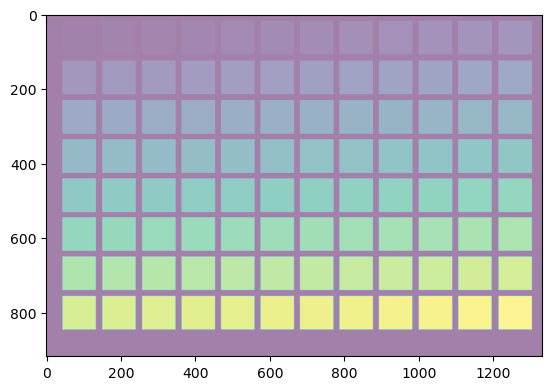

In [157]:

labeled_im_3=np.zeros((len(labeled_image),len(labeled_image[0])))
labeled_im_3[:-30,:-20]=labeled_image[30:,20:]
#do overlay of labeled_image with plots 1
#plt.imshow(sticky_p1_emm_4_w)
plt.imshow(labeled_im_3, alpha=0.5)

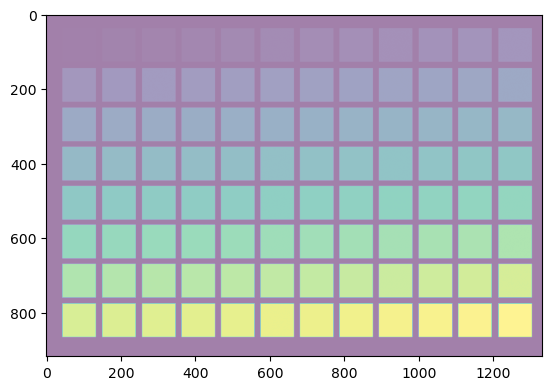

In [158]:


labeled_im_4=np.zeros((len(labeled_image),len(labeled_image[0])))
#Move it down and slighlty right
labeled_im_4[:-10,:-20]=labeled_image[10:,20:]

#plt.imshow(sticky_p1_emm_8)
plt.imshow(labeled_im_4, alpha=0.5)
#move it up and slighlty right

In [159]:
#load in layouts
sticky1 = pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/Screen_BK_plate_1.xlsx",header=None)
#retain only first 12 columns
sticky1=sticky1.iloc[:,:12]
sticky2 = pd.read_excel("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/Screen_BK_plate_2.xlsx",header=None)
#retain only first 12 columns
sticky2=sticky2.iloc[:,:12]
layout_sticky1 = layout_from_map(sticky1)
layout_sticky2 = layout_from_map(sticky2)

#Sticky plate 1 EMM
sticky_p1_emm = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 10/march 10/images/20230310_1_biofilm_bioneer_stick1p1_1234_1.jpg")
sticky_p1_emm_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 10/march 10/images/20230310_1_biofilm_bioneer_stick1p1_1234_1_w.jpg")
sticky_p1_emm_2 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 10/march 10/images/20230310_2_biofilm_bioneer_stick1p1_1234_2.jpg")
sticky_p1_emm_2_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 10/march 10/images/20230310_2_biofilm_bioneer_stick1p1_1234_2_w.jpg")
sticky_p1_emm_3 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 10/march 10/images/20230310_3_biofilm_bioneer_stick1p1_1234_3.jpg")
sticky_p1_emm_3_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 10/march 10/images/20230310_3_biofilm_bioneer_stick1p1_1234_3_w.jpg")
sticky_p1_emm_4 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 10/march 10/images/20230310_4_biofilm_bioneer_stick1p1_1234_4.jpg")
sticky_p1_emm_4_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 10/march 10/images/20230310_4_biofilm_bioneer_stick1p1_1234_4_w.jpg")

sticky_p1_emm_5 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 10/march 10/images/20230310_1_biofilm_bioneer_stick1p1_5.jpg")
sticky_p1_emm_5_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 10/march 10/images/20230310_1_biofilm_bioneer_stick1p1_5_w.jpg")

sticky_p1_emm_6 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p1_1234_round2_/20230320_1_biofilm_bioneer_stick1p1_1234_round2_.jpg")
sticky_p1_emm_6_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p1_1234_round2_w/20230320_1_biofilm_bioneer_stick1p1_1234_round2_w.jpg")
sticky_p1_emm_7 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p1_1234_round2_/20230320_2_biofilm_bioneer_stick1p1_1234_round2_.jpg")
sticky_p1_emm_7_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p1_1234_round2_w/20230320_2_biofilm_bioneer_stick1p1_1234_round2_w.jpg")
sticky_p1_emm_8 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p1_1234_round2_/20230320_3_biofilm_bioneer_stick1p1_1234_round2_.jpg")
sticky_p1_emm_8_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p1_1234_round2_w/20230320_3_biofilm_bioneer_stick1p1_1234_round2_w.jpg")
sticky_p1_emm_9 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p1_1234_round2_/20230320_4_biofilm_bioneer_stick1p1_1234_round2_.jpg")
sticky_p1_emm_9_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p1_1234_round2_w/20230320_4_biofilm_bioneer_stick1p1_1234_round2_w.jpg")


sticky_p1_emm_10 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p1_hd_emm/20230411_1_biofilm_p1_hd_emm.jpg")
sticky_p1_emm_10_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p1_hd_emm_w/20230411_1_biofilm_p1_hd_emm_w.jpg")
sticky_p1_emm_11 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p1_hd_emm/20230411_2_biofilm_p1_hd_emm.jpg")
sticky_p1_emm_11_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p1_hd_emm_w/20230411_2_biofilm_p1_hd_emm_w.jpg")
sticky_p1_emm_12 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p1_hd_emm/20230411_3_biofilm_p1_hd_emm.jpg")
sticky_p1_emm_12_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p1_hd_emm_w/20230411_3_biofilm_p1_hd_emm_w.jpg")
sticky_p1_emm_13 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p1_ld_emm/20230411_1_biofilm_p1_ld_emm.jpg")
sticky_p1_emm_13_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p1_ld_emm_w/20230411_1_biofilm_p1_ld_emm_w.jpg")
sticky_p1_emm_14 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p1_ld_emm/20230411_2_biofilm_p1_ld_emm.jpg")
sticky_p1_emm_14_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p1_ld_emm_w/20230411_2_biofilm_p1_ld_emm_w.jpg")
sticky_p1_emm_15 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p1_ld_emm/20230411_3_biofilm_p1_ld_emm.jpg")
sticky_p1_emm_15_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p1_ld_emm_w/20230411_3_biofilm_p1_ld_emm_w.jpg")



df_sticky_p1_emm_1= processing(sticky_p1_emm,sticky_p1_emm_w,1,plate,layout_sticky1,labeled_im_1,False)
df_sticky_p1_emm_2= processing(sticky_p1_emm_2,sticky_p1_emm_2_w,2,plate,layout_sticky1,labeled_im_2,False)
df_sticky_p1_emm_3= processing(sticky_p1_emm_3,sticky_p1_emm_3_w,3,plate,layout_sticky1,labeled_im_1,False)
df_sticky_p1_emm_4= processing(sticky_p1_emm_4,sticky_p1_emm_4_w,4,plate,layout_sticky1,labeled_im_3,False)
df_sticky_p1_emm_5= processing(sticky_p1_emm_5,sticky_p1_emm_5_w,5,plate,layout_sticky1,labeled_im_1,False)
df_sticky_p1_emm_6= processing(sticky_p1_emm_6,sticky_p1_emm_6_w,6,plate,layout_sticky1,labeled_im_1,False)
df_sticky_p1_emm_7= processing(sticky_p1_emm_7,sticky_p1_emm_7_w,7,plate,layout_sticky1,labeled_im_2,False)
df_sticky_p1_emm_8= processing(sticky_p1_emm_8,sticky_p1_emm_8_w,8,plate,layout_sticky1,labeled_im_4,False)
df_sticky_p1_emm_9= processing(sticky_p1_emm_9,sticky_p1_emm_9_w,9,plate,layout_sticky1,labeled_im_3,False)
df_sticky_p1_emm_10= processing(sticky_p1_emm_10,sticky_p1_emm_10_w,10,plate,layout_sticky1,labeled_im_1,False)
df_sticky_p1_emm_11= processing(sticky_p1_emm_11,sticky_p1_emm_11_w,11,plate,layout_sticky1,labeled_im_2,False)
df_sticky_p1_emm_12= processing(sticky_p1_emm_12,sticky_p1_emm_12_w,12,plate,layout_sticky1,labeled_im_4,False)
df_sticky_p1_emm_13= processing(sticky_p1_emm_13,sticky_p1_emm_13_w,13,plate,layout_sticky1,labeled_im_1,False)
df_sticky_p1_emm_14= processing(sticky_p1_emm_14,sticky_p1_emm_14_w,14,plate,layout_sticky1,labeled_im_2,False)
df_sticky_p1_emm_15= processing(sticky_p1_emm_15,sticky_p1_emm_15_w,15,plate,layout_sticky1,labeled_im_4,False)


#Sticky plate 2 EMM

sticky_p2_emm_1 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p2_1234_round2_/20230320_1_biofilm_bioneer_stick1p2_1234_round2_.jpg")
sticky_p2_emm_1_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p2_1234_round2_w/20230320_1_biofilm_bioneer_stick1p2_1234_round2_w.jpg")
sticky_p2_emm_2 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p2_1234_round2_/20230320_2_biofilm_bioneer_stick1p2_1234_round2_.jpg")
sticky_p2_emm_2_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p2_1234_round2_w/20230320_2_biofilm_bioneer_stick1p2_1234_round2_w.jpg")
sticky_p2_emm_3 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p2_1234_round2_/20230320_3_biofilm_bioneer_stick1p2_1234_round2_.jpg")
sticky_p2_emm_3_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p2_1234_round2_w/20230320_3_biofilm_bioneer_stick1p2_1234_round2_w.jpg")
sticky_p2_emm_4 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p2_1234_round2_/20230320_4_biofilm_bioneer_stick1p2_1234_round2_.jpg")
sticky_p2_emm_4_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p2_1234_round2_w/20230320_4_biofilm_bioneer_stick1p2_1234_round2_w.jpg")
sticky_p2_emm_5 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p2_5_round2_/20230320_1_biofilm_bioneer_stick1p2_5_round2_.jpg")
sticky_p2_emm_5_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb march 20/20230320_biofilm_bioneer_stick1p2_5_round2_w/20230320_1_biofilm_bioneer_stick1p2_5_round2_w.jpg")
sticky_p2_emm_6 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p2_hd_emm/20230411_1_biofilm_p2_hd_emm.jpg")
sticky_p2_emm_6_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p2_hd_emm_w/20230411_1_biofilm_p2_hd_emm_w.jpg")
sticky_p2_emm_7 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p2_hd_emm/20230411_2_biofilm_p2_hd_emm.jpg")    
sticky_p2_emm_7_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p2_hd_emm_w/20230411_2_biofilm_p2_hd_emm_w.jpg")
sticky_p2_emm_8 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p2_hd_emm/20230411_3_biofilm_p2_hd_emm.jpg")
sticky_p2_emm_8_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 11/20230411_biofilm_p2_hd_emm_w/20230411_3_biofilm_p2_hd_emm_w.jpg")


df_sticky_p2_emm_1= processing(sticky_p2_emm_1,sticky_p2_emm_1_w,1,plate,layout_sticky2,labeled_im_1,False)
df_sticky_p2_emm_2= processing(sticky_p2_emm_2,sticky_p2_emm_2_w,2,plate,layout_sticky2,labeled_im_2,False)
df_sticky_p2_emm_3= processing(sticky_p2_emm_3,sticky_p2_emm_3_w,3,plate,layout_sticky2,labeled_im_4,False)
df_sticky_p2_emm_4= processing(sticky_p2_emm_4,sticky_p2_emm_4_w,4,plate,layout_sticky2,labeled_im_3,False)
df_sticky_p2_emm_5= processing(sticky_p2_emm_5,sticky_p2_emm_5_w,5,plate,layout_sticky2,labeled_im_1,False)
df_sticky_p2_emm_6= processing(sticky_p2_emm_6,sticky_p2_emm_6_w,6,plate,layout_sticky2,labeled_im_1,False)
df_sticky_p2_emm_7= processing(sticky_p2_emm_7,sticky_p2_emm_7_w,7,plate,layout_sticky2,labeled_im_2,False)
df_sticky_p2_emm_8= processing(sticky_p2_emm_8,sticky_p2_emm_8_w,8,plate,layout_sticky2,labeled_im_4,False)

#Sticky plate 1 YES
sticky_p1_yes_1 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky1_p1234_yes_/20230324_1_biofilm_bioneer_sticky1_p1234_yes_.jpg")
sticky_p1_yes_1_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky1_p1234_yes_w/20230324_1_biofilm_bioneer_sticky1_p1234_yes_w.jpg")
sticky_p1_yes_2 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky1_p1234_yes_/20230324_2_biofilm_bioneer_sticky1_p1234_yes_.jpg")
sticky_p1_yes_2_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky1_p1234_yes_w/20230324_2_biofilm_bioneer_sticky1_p1234_yes_w.jpg")
sticky_p1_yes_3 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky1_p1234_yes_/20230324_3_biofilm_bioneer_sticky1_p1234_yes_.jpg")
sticky_p1_yes_3_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky1_p1234_yes_w/20230324_3_biofilm_bioneer_sticky1_p1234_yes_w.jpg")
sticky_p1_yes_4 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky1_p1234_yes_/20230324_4_biofilm_bioneer_sticky1_p1234_yes_.jpg")
sticky_p1_yes_4_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky1_p1234_yes_w/20230324_4_biofilm_bioneer_sticky1_p1234_yes_w.jpg")


df_sticky_p1_yes_1= processing(sticky_p1_yes_1,sticky_p1_yes_1_w,1,plate,layout_sticky1,labeled_im_1,False)
df_sticky_p1_yes_2= processing(sticky_p1_yes_2,sticky_p1_yes_2_w,2,plate,layout_sticky1,labeled_im_2,False)
df_sticky_p1_yes_3= processing(sticky_p1_yes_3,sticky_p1_yes_3_w,3,plate,layout_sticky1,labeled_im_4,False)
df_sticky_p1_yes_4= processing(sticky_p1_yes_4,sticky_p1_yes_4_w,4,plate,layout_sticky1,labeled_im_3,False)




#Sticky plate 2 YES
sticky_p2_yes_1 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky2_p1234_yes_/20230324_1_biofilm_bioneer_sticky2_p1234_yes_.jpg")
sticky_p2_yes_1_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky2_p1234_yes_w/20230324_1_biofilm_bioneer_sticky2_p1234_yes_w.jpg")
sticky_p2_yes_2 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky2_p1234_yes_/20230324_2_biofilm_bioneer_sticky2_p1234_yes_.jpg")
sticky_p2_yes_2_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky2_p1234_yes_w/20230324_2_biofilm_bioneer_sticky2_p1234_yes_w.jpg")
sticky_p2_yes_3 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky2_p1234_yes_/20230324_3_biofilm_bioneer_sticky2_p1234_yes_.jpg")
sticky_p2_yes_3_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky2_p1234_yes_w/20230324_3_biofilm_bioneer_sticky2_p1234_yes_w.jpg")
sticky_p2_yes_4 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky2_p1234_yes_/20230324_4_biofilm_bioneer_sticky2_p1234_yes_.jpg")
sticky_p2_yes_4_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky2_p1234_yes_w/20230324_4_biofilm_bioneer_sticky2_p1234_yes_w.jpg")
sticky_p2_yes_5 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky2_p56_yes_/20230324_1_biofilm_bioneer_sticky2_p56_yes_.jpg")
sticky_p2_yes_5_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky2_p56_yes_w/20230324_1_biofilm_bioneer_sticky2_p56_yes_w.jpg")
sticky_p2_yes_6 = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky2_p56_yes_/20230324_2_biofilm_bioneer_sticky2_p56_yes_.jpg")
sticky_p2_yes_6_w = import_im("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/data from usb apr 5/20230324_biofilm_bioneer_sticky2_p56_yes_w/20230324_2_biofilm_bioneer_sticky2_p56_yes_w.jpg")


df_sticky_p2_yes_1 = processing(sticky_p2_yes_1,sticky_p2_yes_1_w,1,plate,layout_sticky2,labeled_im_1,False)
df_sticky_p2_yes_2 = processing(sticky_p2_yes_2,sticky_p2_yes_2_w,2,plate,layout_sticky2,labeled_im_2,False)
df_sticky_p2_yes_3 = processing(sticky_p2_yes_3,sticky_p2_yes_3_w,3,plate,layout_sticky2,labeled_im_4,False)
df_sticky_p2_yes_4 = processing(sticky_p2_yes_4,sticky_p2_yes_4_w,4,plate,layout_sticky2,labeled_im_3,False)
df_sticky_p2_yes_5 = processing(sticky_p2_yes_5,sticky_p2_yes_5_w,5,plate,layout_sticky2,labeled_im_1,False)
df_sticky_p2_yes_6 = processing(sticky_p2_yes_6,sticky_p2_yes_6_w,6,plate,layout_sticky2,labeled_im_2,False)







/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/1896631122.py:161: FutureWarning: The default value of regex will change from True to False in a future version.
  df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/1896631122.py:161: FutureWarning: The default value of regex will change from True to False in a future version.
  df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/1896631122.py:161: FutureWarning: The default value of regex will change from True to False in a future version.
  df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/1896631122.py:161: FutureWarning: The default value of regex will change from True to False in a future version.
  df["position"]=df["position"].str.replace("([A-Z])([0-9])",r"\1_\2")
/var

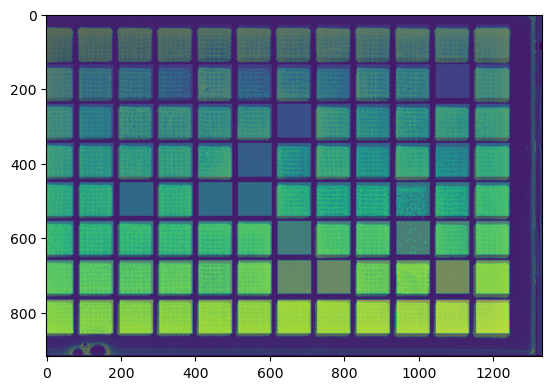

In [160]:
plt.imshow(sticky_p2_yes_6)
plt.imshow(labeled_im_2, alpha=0.5)
#move it up and slighlty right


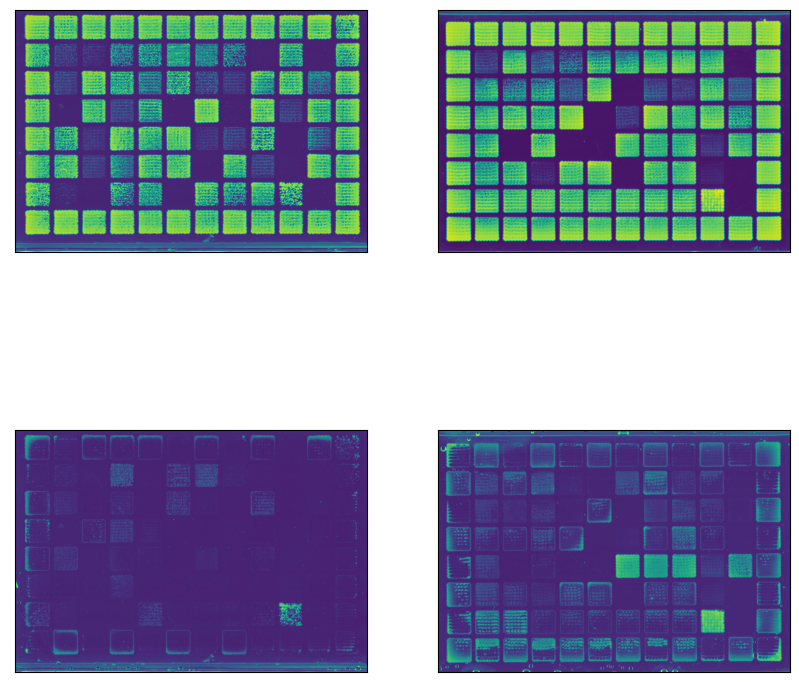

In [161]:

#WRITE A FUNCTION THAT TAKES 4 IMAGES AND PRINTS THEM OUT IN 2 ROWS
def plotfour(im1,im2,im3,im4):
      fig, ax = plt.subplots(2,2,figsize=(10,10))
      im1 = im1/np.max(im1)
      im1 = im1-np.min(im1)
      im2 = im2/np.max(im2)
      im2 = im2-np.min(im2)
      im3 = im3/np.max(im3)
      im3 = im3-np.min(im3)
      im4 = im4/np.max(im4)
      im4 = im4-np.min(im4)

      ax[0,0].imshow(im1)
      ax[0,1].imshow(im2)
      ax[1,0].imshow(im3)
      ax[1,1].imshow(im4)
      #remove ticks
      ax[0,0].set_xticks([])
      ax[0,0].set_yticks([])
      ax[0,1].set_xticks([])
      ax[0,1].set_yticks([])
      ax[1,0].set_xticks([])
      ax[1,0].set_yticks([])
      ax[1,1].set_xticks([])
      ax[1,1].set_yticks([])
      plt.show()
      return

plotfour(sticky_p1_emm_4,sticky_p2_emm_6,sticky_p1_emm_4_w,sticky_p2_emm_6_w)

In [162]:
np.min(sticky_p1_yes_4)

0

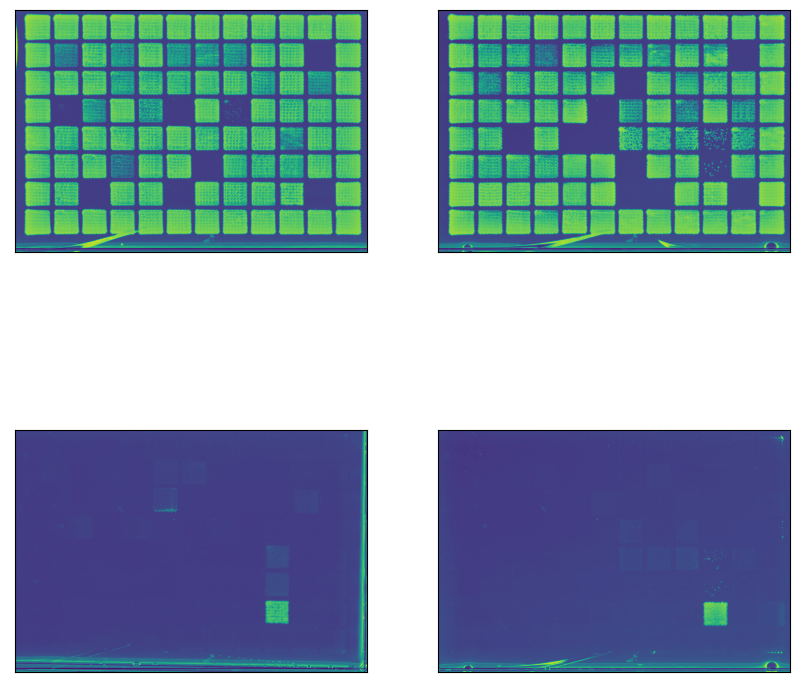

In [163]:
plotfour(sticky_p1_yes_4,sticky_p2_yes_4,sticky_p1_yes_4_w,sticky_p2_yes_4_w)

# Plate 1 EMM

In [164]:
#concat these dfs
df_sticky_p1_emm = pd.concat([df_sticky_p1_emm_1,df_sticky_p1_emm_2,df_sticky_p1_emm_3,df_sticky_p1_emm_4,df_sticky_p1_emm_5,
                              df_sticky_p1_emm_6,df_sticky_p1_emm_7,df_sticky_p1_emm_8,df_sticky_p1_emm_9,df_sticky_p1_emm_10,
                              df_sticky_p1_emm_11,df_sticky_p1_emm_12,df_sticky_p1_emm_13,df_sticky_p1_emm_14,df_sticky_p1_emm_15])

#remove entries with before_wash<0.1
df_sticky_p1_emm = df_sticky_p1_emm[df_sticky_p1_emm['before_wash']>0.1]
#reset
df_sticky_p1_emm = df_sticky_p1_emm.reset_index(drop=True)
#make a column where entries are lists of all ratio values for a given strain
#create a column called ratio_list with type list
ratio_list = []
n=[]
for i in df_sticky_p1_emm['strain']:
      subset= df_sticky_p1_emm.loc[df_sticky_p1_emm["strain"]==i]
      indices = subset.index
      ratios = subset['ratio'].tolist()
      ratio_list.append(ratios)
      n.append(len(ratios))
df_sticky_p1_emm['ratio_list'] = ratio_list
df_sticky_p1_emm['n'] = n
#remove entreis with JB50 or JB759
df_sticky_p1_emm = df_sticky_p1_emm[~df_sticky_p1_emm['strain'].isin(['JB50','JB759'])]
#results df to have mean and sem of each strain
results_sticky_p1_emm = df_sticky_p1_emm.groupby(['strain']).agg({'before_wash':['mean','sem'],'after_wash':['mean','sem'],'ratio':['mean','sem']})
results_sticky_p1_emm.columns = ['_'.join(col).strip() for col in results_sticky_p1_emm.columns.values]
results_sticky_p1_emm = results_sticky_p1_emm.reset_index()
#sort byr atio
results_sticky_p1_emm = results_sticky_p1_emm.sort_values(by=['ratio_mean'],ascending=False)
#add back column n and ratio list
ratio_list = []
n=[]
for i in results_sticky_p1_emm['strain']:
      subset= df_sticky_p1_emm.loc[df_sticky_p1_emm["strain"]==i]
      indices = subset.index
      ratios = subset['ratio'].tolist()
      ratio_list.append(ratios)
      n.append(len(ratios))
results_sticky_p1_emm['ratio_list'] = ratio_list
results_sticky_p1_emm['n'] = n

#more than 5 n 
results_sticky_p1_emm = results_sticky_p1_emm[results_sticky_p1_emm['n']>5]

results_sticky_p1_emm



strain  before_wash_mean  before_wash_sem  after_wash_mean  \
0          JB914          0.405654         0.040161         0.315639   
13          dcd1          0.316090         0.022209         0.139054   
40       rpl3602          0.329095         0.015324         0.144692   
37       rpl2102          0.333419         0.020831         0.127344   
43          shm1          0.175120         0.016896         0.064178   
28          npr2          0.134442         0.010433         0.048941   
5    SPBP8B7.18c          0.228720         0.040834         0.054320   
47         tom70          0.294266         0.018098         0.063580   
11          csk1          0.421034         0.018735         0.087738   
38       rpl2702          0.414989         0.023738         0.081302   
21          hst4          0.404121         0.019496         0.073254   
46          thi4          0.264833         0.050860         0.039610   
39       rpl3202          0.215638         0.022874         0.036198   
41        rps602          0.266111         0.011694         0.047089   
48        trs402          0.369472         0.030421         0.050427   
33          res2          0.432515         0.012927         0.062007   
29          pda1          0.235536         0.043884         0.030084   
36       rpl2101          0.209247         0.021999         0.027674   
44          sre2          0.454423         0.016236         0.060680   
6          alp14          0.201687         0.017838         0.025964   
45          sxa1          0.208999         0.021910         0.024666   
35          rik1          0.184143         0.016062         0.021382   
27          mtq2          0.325521         0.025578         0.029948   
22         mdm31          0.201589         0.028610         0.023830   
30          pdp1          0.418796         0.021326         0.038359   
18          his5          0.486237         0.014032         0.040040   
34          rex1          0.383739         0.023077         0.030567   
14          dph1          0.427501         0.011584         0.034386   
15          fil1          0.264796         0.026501         0.018952   
19          hom6          0.455070         0.014093         0.032190   
9           cdt2          0.237072         0.013826         0.017047   
8           ccs1          0.497769         0.014338         0.032482   
16          gdh2          0.224665         0.015517         0.014222   
10          cph2          0.506860         0.014939         0.031471   
26          mtd1          0.497265         0.011650         0.025362   
23          mik1          0.457603         0.013382         0.022664   
24          mod5          0.514411         0.014197         0.025391   
17          gid4          0.563645         0.013271         0.026639   
25        mss116          0.270760         0.013217         0.013245   
32          rer1          0.554639         0.014639         0.022638   
49         ypt71          0.463979         0.018942         0.018826   
31         pof14          0.451974         0.023425         0.017049   
12          csn4          0.532094         0.013303         0.018743   
3    SPAC977.14c          0.496944         0.016593         0.017421   
42         sec67          0.466075         0.018263         0.014442   
20          hos2          0.513012         0.013974         0.016099   
2   SPAC14C4.10c          0.555094         0.012488         0.016277   
4     SPBC83.16c          0.504983         0.013620         0.012465   
7           byr3          0.572371         0.014899         0.013523   

    after_wash_sem  ratio_mean  ratio_sem  \
0         0.038545    0.770597   0.041512   
13        0.011800    0.460074   0.042143   
40        0.018115    0.431294   0.044116   
37        0.019674    0.385753   0.050629   
43        0.015738    0.354162   0.051143   
28        0.013517    0.335693   0.064607   
5         0.006546    0.331352   0.070228   
47        0.007601    0.218378   0.025465   
11  

# Plate 2 EMM

In [165]:
#concat these dfs
df_sticky_p2_emm = pd.concat([df_sticky_p2_emm_1,df_sticky_p2_emm_2,df_sticky_p2_emm_3,df_sticky_p2_emm_4,df_sticky_p2_emm_5,
                              df_sticky_p2_emm_6,df_sticky_p2_emm_7,df_sticky_p2_emm_8])
#remove entries with before_wash<0.1
df_sticky_p2_emm = df_sticky_p2_emm[df_sticky_p2_emm['before_wash']>0.1]
#reset
df_sticky_p2_emm = df_sticky_p2_emm.reset_index(drop=True)
#make a column where entries are lists of all ratio values for a given strain
#create a column called ratio_list with type list
ratio_list = []
n=[]
for i in df_sticky_p2_emm['strain']:
      subset= df_sticky_p2_emm.loc[df_sticky_p2_emm["strain"]==i]
      indices = subset.index
      ratios = subset['ratio'].tolist()
      ratio_list.append(ratios)
      n.append(len(ratios))
df_sticky_p2_emm['ratio_list'] = ratio_list
df_sticky_p2_emm['n'] = n



#remove entreis with JB50 or JB759
df_sticky_p2_emm = df_sticky_p2_emm[~df_sticky_p2_emm['strain'].isin(['JB50','JB759'])]



#results df to have mean and sem of each strain
results_sticky_p2_emm = df_sticky_p2_emm.groupby(['strain']).agg({'before_wash':['mean','sem'],'after_wash':['mean','sem'],'ratio':['mean','sem']})
results_sticky_p2_emm.columns = ['_'.join(col).strip() for col in results_sticky_p2_emm.columns.values]
results_sticky_p2_emm = results_sticky_p2_emm.reset_index()
#sort byr atio
results_sticky_p2_emm = results_sticky_p2_emm.sort_values(by=['ratio_mean'],ascending=False)


ratio_list = []
n=[]
for i in results_sticky_p2_emm['strain']:
      subset= df_sticky_p2_emm.loc[df_sticky_p2_emm["strain"]==i]
      indices = subset.index
      ratios = subset['ratio'].tolist()
      ratio_list.append(ratios)
      n.append(len(ratios))
results_sticky_p2_emm['ratio_list'] = ratio_list
results_sticky_p2_emm['n'] = n
#more than 5 n
results_sticky_p2_emm = results_sticky_p2_emm[results_sticky_p2_emm['n']>5]
results_sticky_p2_emm


strain  before_wash_mean  before_wash_sem  after_wash_mean  \
0              JB914          0.427337         0.050633         0.380794   
44             srb11          0.464371         0.014544         0.351479   
43             srb10          0.413378         0.024164         0.264533   
29              mmp1          0.157289         0.021509         0.086023   
15   SPNCRNA.900.2-2          0.433009         0.031291         0.191715   
14   SPNCRNA.900.2-1          0.420844         0.026234         0.188840   
9   SPNCRNA.1234.3-2          0.311612         0.066466         0.086175   
8   SPNCRNA.1234.3-1          0.289538         0.067124         0.071489   
45              ssb3          0.149591         0.018555         0.042401   
6   SPNCRNA.1234.2-1          0.321719         0.055273         0.072057   
7   SPNCRNA.1234.2-2          0.338976         0.053715         0.075997   
22              fkh2          0.408598         0.038738         0.105879   
41             rrp17          0.436289         0.020014         0.112142   
26             med13          0.422979         0.019451         0.078831   
4        SPAC607.02c          0.432000         0.021248         0.082528   
35              puf4          0.443310         0.017919         0.073657   
47             yta12          0.317944         0.029443         0.054777   
37              rox3          0.430728         0.023388         0.065797   
30            mug165          0.460428         0.014568         0.069106   
5       SPBC18E5.09c          0.205137         0.028303         0.033458   
39           rpl3702          0.367740         0.011266         0.053173   
27             med18          0.543056         0.018979         0.073687   
36              reb1          0.363244         0.025629         0.053792   
11   SPNCRNA.781.2-2          0.556217         0.011173         0.069566   
40              rpt6          0.574713         0.018494         0.070251   
12   SPNCRNA.781.3-1          0.516654         0.008332         0.061646   
38           rpl2002          0.428580         0.035755         0.046351   
18              ade3          0.196081         0.017099         0.021685   
16   SPNCRNA.900.3-1          0.459897         0.021176         0.049370   
23              ipk1          0.470078         0.020209         0.050272   
19             cdc73          0.550959         0.015017         0.056413   
3       SPAC23A1.14c          0.214445         0.028362         0.023644   
10   SPNCRNA.781.2-1          0.515657         0.007853         0.048794   
28             meu22          0.188399         0.014050         0.017081   
17   SPNCRNA.900.3-2          0.473239         0.020801         0.037182   
21              dml1          0.486566         0.020182         0.038501   
32              phb2          0.498241         0.016493         0.037732   
20              coa2          0.271593         0.045843         0.013234   
24              lkh1          0.527916         0.014606         0.028651   
31        nut2/med10          0.364842         0.025710         0.017244   
33              pmc3          0.519272         0.015087         0.023431   

    after_wash_sem  ratio_mean  ratio_sem  \
0         0.042263    0.892056   0.024124   
44        0.021698    0.751566   0.032258   
43        0.029438    0.652088   0.068196   
29        0.016245    0.530057   0.061768   
15        0.008912    0.453589   0.030875   
14        0.007725    0.453212   0.021152   
9         0.020573    0.362827   0.115250   
8         0.013980    0.331035   0.097274   
45        0.005191    0.291792   0.028882   
6         0.014719    0.284413   0.082442   
7         0.016350    0.277539   0.082998   
22        0.012831    0.272690   0.038492   
41        0.015260    0.252070   0.025612   
26        0.006917    0.192585   0.017875   
4         0.010962    0.191874   0.026408   
35        0.006327    0.170157   0.018943   
47        0.013763    0.159460   0.029557   
37        0

In [166]:
#results_sticky_p1_emm csk1
results_sticky_p1_emm[results_sticky_p1_emm['strain'].isin(['sre2'])]


strain  before_wash_mean  before_wash_sem  after_wash_mean  after_wash_sem  \
44   sre2          0.454423         0.016236          0.06068        0.004875   

    ratio_mean  ratio_sem                                         ratio_list  \
44    0.135441   0.011596  [0.0562861855808374, 0.08153272129403064, 0.14...   

     n  
44  15

# Plate 1 YES


In [167]:
#concat these dfs
df_sticky_p1_yes = pd.concat([df_sticky_p1_yes_1,df_sticky_p1_yes_2,df_sticky_p1_yes_3,df_sticky_p1_yes_4])
df_sticky_p1_yes = df_sticky_p1_yes[df_sticky_p1_yes['before_wash']>0.1]
#reset
df_sticky_p1_yes = df_sticky_p1_yes.reset_index(drop=True)
#make a column where entries are lists of all ratio values for a given strain
#create a column called ratio_list with type list
ratio_list = []
n=[]
for i in df_sticky_p1_yes['strain']:
      subset= df_sticky_p1_yes.loc[df_sticky_p1_yes["strain"]==i]
      indices = subset.index
      ratios = subset['ratio'].tolist()
      ratio_list.append(ratios)
      n.append(len(ratios))
df_sticky_p1_yes['ratio_list'] = ratio_list
df_sticky_p1_yes['n'] = n
#remove entreis with JB50 or JB759
df_sticky_p1_yes = df_sticky_p1_yes[~df_sticky_p1_yes['strain'].isin(['JB50','JB759'])]
#results df to have mean and sem of each strain
results_sticky_p1_yes = df_sticky_p1_yes.groupby(['strain']).agg({'before_wash':['mean','sem'],'after_wash':['mean','sem'],'ratio':['mean','sem']})
results_sticky_p1_yes.columns = ['_'.join(col).strip() for col in results_sticky_p1_yes.columns.values]
results_sticky_p1_yes = results_sticky_p1_yes.reset_index()
#sort byr atio
results_sticky_p1_yes = results_sticky_p1_yes.sort_values(by=['ratio_mean'],ascending=False)
#add back column n and ratio list
ratio_list = []
n=[]
for i in results_sticky_p1_yes['strain']:
      subset= df_sticky_p1_yes.loc[df_sticky_p1_yes["strain"]==i]
      indices = subset.index
      ratios = subset['ratio'].tolist()
      ratio_list.append(ratios)
      n.append(len(ratios))
results_sticky_p1_yes['ratio_list'] = ratio_list
results_sticky_p1_yes['n'] = n



results_sticky_p1_yes.reset_index(drop=True,inplace=True)
results_sticky_p1_yes

strain  before_wash_mean  before_wash_sem  after_wash_mean  \
0          JB914          0.487645         0.017433         0.405926   
1             R7          0.251479         0.018389         0.042372   
2           sre2          0.450445         0.011732         0.064223   
3           ccs1          0.517470         0.015207         0.061170   
4             R4          0.415687         0.005502         0.047100   
5         rps602          0.318123         0.010804         0.034476   
6        rpl3602          0.353011         0.013429         0.037314   
7        rpl2102          0.324925         0.010067         0.031185   
8          tom70          0.158910         0.007442         0.012324   
9        rpl2702          0.327041         0.010718         0.025968   
10          npr2          0.188955         0.016888         0.012479   
11          mtq2          0.342057         0.008304         0.020674   
12          rex1          0.296353         0.008535         0.014308   
13          dcd1          0.302658         0.010767         0.013780   
14         alp14          0.499537         0.013029         0.020455   
15          sxa1          0.451346         0.009885         0.016834   
16        mss116          0.457161         0.011047         0.016517   
17          hst4          0.358369         0.012043         0.013019   
18          csk1          0.387741         0.010288         0.012172   
19         mdm31          0.504625         0.012855         0.015805   
20          pdp1          0.530397         0.014940         0.015946   
21          rik1          0.505938         0.009587         0.014948   
22          shm1          0.509911         0.012448         0.014392   
23    SPBC83.16c          0.530890         0.015623         0.015069   
24          dph1          0.491187         0.015415         0.014094   
25   SPAC977.14c          0.527919         0.016257         0.014919   
26          hos2          0.507926         0.014117         0.013532   
27          rer1          0.523679         0.016983         0.013688   
28          his5          0.552945         0.016911         0.014260   
29         sec67          0.449540         0.007608         0.011223   
30    SPAC144.01          0.510795         0.016655         0.012861   
31          res2          0.518642         0.013248         0.012807   
32          gdh2          0.494770         0.017838         0.012300   
33          hom6          0.496359         0.010267         0.012246   
34         pof14          0.527538         0.013630         0.012900   
35          fil1          0.514699         0.015536         0.012248   
36       rpl3202          0.465328         0.012240         0.010958   
37          cph2          0.487093         0.010673         0.010682   
38          gid4          0.525998         0.013101         0.011362   
39          mod5          0.536167         0.013567         0.011247   
40         ypt71          0.533995         0.014855         0.011299   
41          byr3          0.555999         0.015061         0.011824   
42        trs402          0.456182         0.011406         0.009377   
43       rpl2101          0.503818         0.014567         0.010178   
44          thi4          0.526179         0.014184         0.010790   
45          cdt2          0.510459         0.012783         0.010208   
46          mik1          0.505021         0.011865         0.009997   
47          mtd1          0.500899         0.010710         0.009785   
48  SPAC14C4.10c          0.548666         0.014260         0.010683   
49   SPBP8B7.18c          0.540052         0.012878         0.010184   
50          pda1          0.475441         0.013353         0.009054   
51          csn4          0.516378         0.013361         0.009291   

    after_wash_sem  ratio_mean  ratio_sem  \
0         0.082721    0.827449   0.160140   
1         0.007257    0.176098   0.036761   
2         0.014569    0.141671   0.030318   
3         0.0

# Plate 2 YES

In [168]:
df_sticky_p2_yes = pd.concat([df_sticky_p2_yes_1,df_sticky_p2_yes_2,df_sticky_p2_yes_3,df_sticky_p2_yes_4])
#remove entries with before_wash<0.1
df_sticky_p2_yes = df_sticky_p2_yes[df_sticky_p2_yes['before_wash']>0.1]
#reset
df_sticky_p2_yes = df_sticky_p2_yes.reset_index(drop=True)
#make a column where entries are lists of all ratio values for a given strain
#create a column called ratio_list with type list
ratio_list = []
n=[]
for i in df_sticky_p2_yes['strain']:
      subset= df_sticky_p2_yes.loc[df_sticky_p2_yes["strain"]==i]
      indices = subset.index
      ratios = subset['ratio'].tolist()
      ratio_list.append(ratios)
      n.append(len(ratios))
df_sticky_p2_yes['ratio_list'] = ratio_list
df_sticky_p2_yes['n'] = n
#remove entreis with JB50 or JB759
df_sticky_p2_yes = df_sticky_p2_yes[~df_sticky_p2_yes['strain'].isin(['JB50','JB759'])]
#results df to have mean and sem of each strain
results_sticky_p2_yes = df_sticky_p2_yes.groupby(['strain']).agg({'before_wash':['mean','sem'],'after_wash':['mean','sem'],'ratio':['mean','sem']})
results_sticky_p2_yes.columns = ['_'.join(col).strip() for col in results_sticky_p2_yes.columns.values]
results_sticky_p2_yes = results_sticky_p2_yes.reset_index()
#sort byr atio
results_sticky_p2_yes = results_sticky_p2_yes.sort_values(by=['ratio_mean'],ascending=False)
#add back column n and ratio list
ratio_list = []
n=[]
for i in results_sticky_p2_yes['strain']:
      subset= df_sticky_p2_yes.loc[df_sticky_p2_yes["strain"]==i]
      indices = subset.index
      ratios = subset['ratio'].tolist()
      ratio_list.append(ratios)
      n.append(len(ratios))
results_sticky_p2_yes['ratio_list'] = ratio_list
results_sticky_p2_yes['n'] = n



results_sticky_p2_yes.reset_index(drop=True,inplace=True)
results_sticky_p2_yes


strain  before_wash_mean  before_wash_sem  after_wash_mean  \
0              JB914          0.532804         0.018840         0.493846   
1              srb10          0.357505         0.015861         0.038431   
2                 R7          0.311268         0.005349         0.033104   
3              rrp17          0.309224         0.034882         0.025605   
4              srb11          0.431420         0.018693         0.038274   
5               mmp1          0.218534         0.036985         0.019141   
6               pos5          0.351410         0.014030         0.028588   
7               coa2          0.317802         0.021128         0.020138   
8               fkh2          0.365895         0.019349         0.023262   
9         nut2/med10          0.279440         0.021926         0.016245   
10             yta12          0.414208         0.020269         0.021055   
11              ssb3          0.500951         0.012554         0.025153   
12   SPNCRNA.900.3-1          0.428333         0.050874         0.021647   
13  SPNCRNA.1234.2-1          0.547170         0.021008         0.025458   
14              ura2          0.394535         0.022221         0.017666   
15             med13          0.441037         0.011448         0.019813   
16             cdc73          0.482593         0.013908         0.021573   
17           rpl2002          0.448031         0.015833         0.018940   
18       SPAC607.02c          0.386613         0.018851         0.016828   
19   SPNCRNA.900.2-2          0.464441         0.042637         0.019491   
20              reb1          0.315722         0.035213         0.014201   
21   SPNCRNA.900.3-2          0.497271         0.037500         0.020240   
22   SPNCRNA.900.2-1          0.489398         0.039958         0.019059   
23   SPNCRNA.781.2-2          0.552347         0.008888         0.021200   
24            mbx2OE          0.446871         0.021553         0.016950   
25  SPNCRNA.1234.3-2          0.495223         0.043078         0.020280   
26              sir1          0.404659         0.019200         0.015269   
27              ipk1          0.450869         0.022676         0.016502   
28   SPNCRNA.781.2-1          0.531663         0.012840         0.019393   
29   SPNCRNA.781.3-1          0.509574         0.007913         0.018110   
30              dml1          0.458332         0.021939         0.015863   
31             meu22          0.444596         0.017744         0.015223   
32              ade3          0.487103         0.018155         0.016428   
33              rox3          0.467203         0.014896         0.015749   
34   SPNCRNA.781.3-2          0.451152         0.029505         0.015759   
35             med18          0.526345         0.019341         0.017029   
36      SPAC23A1.14c          0.493058         0.014524         0.014988   
37              pmc3          0.505497         0.015284         0.015513   
38            mug165          0.438945         0.017512         0.013529   
39           rpl3702          0.486676         0.010807         0.014656   
40      SPBC18E5.09c          0.458440         0.015590         0.013340   
41              phb2          0.468724         0.020611         0.013250   
42              puf4          0.478613         0.019522         0.013449   
43              lkh1          0.517912         0.020548         0.014377   
44              rpt6          0.528565         0.011918         0.014404   

    after_wash_sem  ratio_mean  ratio_sem  \
0         0.012058    0.928665   0.022348   
1         0.003943    0.108024   0.010304   
2         0.004848    0.106117   0.013751   
3         0.006954    0.091643   0.031245   
4         0.003074    0.089001   0.006450   
5         0.004989    0.084238   0.007765   
6         0.006267    0.081293   0.018202   
7         0.002907    0.064584   0.010732   
8         0.003170    0.062866   0.006538   
9         0.006429    0.054718   0.019481   
10        0.002655    

In [169]:
#concat the yes dfs
final_results_yes_screen = pd.concat([results_sticky_p1_yes,results_sticky_p2_yes])
#reset
final_results_yes_screen = final_results_yes_screen.reset_index(drop=True)

for i in ["SPNCRNA.781","SPNCRNA.900","SPNCRNA.1234"]:
      subset = final_results_yes_screen[final_results_yes_screen['strain'].str.contains(i)]
      indices = subset.index
    #remove from df
      final_results_yes_screen = final_results_yes_screen.drop(indices)
      ratios=[k for i in subset['ratio_list'] for k in i]
      ratio_mean = np.mean(ratios)
      ratio_sem = np.std(ratios)/np.sqrt(len(ratios))
      before_wash_mean = np.mean(subset['before_wash_mean'])
      before_wash_sem = np.mean(subset['before_wash_sem'])
      after_wash_mean = np.mean(subset['after_wash_mean'])
      after_wash_sem = np.mean(subset['after_wash_sem'])
      n = np.sum(subset['n'])
      new_row = {'strain':i,'ratio_mean':ratio_mean,'ratio_sem':ratio_sem,'before_wash_mean':before_wash_mean,'before_wash_sem':before_wash_sem,'after_wash_mean':after_wash_mean,'after_wash_sem':after_wash_sem,'ratio_list':ratios,'n':n}
      final_results_yes_screen = final_results_yes_screen.append(new_row,ignore_index=True)
final_results_yes_screen

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/3818759101.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results_yes_screen = final_results_yes_screen.append(new_row,ignore_index=True)
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/3818759101.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results_yes_screen = final_results_yes_screen.append(new_row,ignore_index=True)
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/3818759101.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results_yes_screen = final_results_yes_screen.append(new_row,ignore_index=True)


strain  before_wash_mean  before_wash_sem  after_wash_mean  \
0          JB914          0.487645         0.017433         0.405926   
1             R7          0.251479         0.018389         0.042372   
2           sre2          0.450445         0.011732         0.064223   
3           ccs1          0.517470         0.015207         0.061170   
4             R4          0.415687         0.005502         0.047100   
..           ...               ...              ...              ...   
85          lkh1          0.517912         0.020548         0.014377   
86          rpt6          0.528565         0.011918         0.014404   
87   SPNCRNA.781          0.511184         0.014786         0.018615   
88   SPNCRNA.900          0.469861         0.042742         0.020109   
89  SPNCRNA.1234          0.521196         0.032043         0.022869   

    after_wash_sem  ratio_mean  ratio_sem  \
0         0.082721    0.827449   0.160140   
1         0.007257    0.176098   0.036761   
2         0.014569    0.141671   0.030318   
3         0.045319    0.123718   0.093835   
4         0.009102    0.112956   0.021418   
..             ...         ...        ...   
85        0.005756    0.027267   0.010682   
86        0.003346    0.026935   0.005726   
87        0.006513    0.035520   0.005333   
88        0.004765    0.042373   0.003594   
89        0.007039    0.041836   0.007443   

                                           ratio_list   n  
0   [1.0219328348278702, 0.9489719139253247, 0.989...   4  
1   [0.23914513713307628, 0.21023553163348696, 0.1...   4  
2   [0.2109022071905451, 0.1369760864656442, 0.154...   4  
3   [0.04482214977379228, 0.04669311120442447, 0.0...   4  
4   [0.15186968213050547, 0.13909698554192998, 0.1...   4  
..                                                ...  ..  
85  [0.011503476314942123, 0.008534937996765862, 0...   4  
86  [0.0407654758252287, 0.022498759974833502, 0.0...   4  
87  [0.03689908966444448, 0.017250937723908535, 0....  20  
88  [0.056281187995395686, 0.0400075655536141, 0.0...  16  
89  [0.04274886997176482, 0.03468436277204917, 0.0...   8  

[90 rows x 9 columns]

In [170]:
#Concatenate results_sticky_p2_emm and results_sticky_p1_emm
final_results= pd.concat([results_sticky_p2_emm,results_sticky_p1_emm])
#reset index
final_results = final_results.reset_index(drop=True)
#remove 914 R4 and R7.
final_results = final_results[~final_results['strain'].isin(['JB914','R7','R4'])]
#find all strains with spncrna.781, merge the ratios lists and calculate the summary stats again. Same for spncrna.900 and spncrna.1234
for i in ["SPNCRNA.781","SPNCRNA.900","SPNCRNA.1234"]:
    subset = final_results[final_results['strain'].str.contains(i)]
    indices = subset.index
    #remove from df
    final_results = final_results.drop(indices)
    ratios=[k for i in subset['ratio_list'] for k in i]
    ratio_mean = np.mean(ratios)
    ratio_sem = np.std(ratios)/np.sqrt(len(ratios))
    before_wash_mean = np.mean(subset['before_wash_mean'])
    before_wash_sem = np.mean(subset['before_wash_sem'])
    after_wash_mean = np.mean(subset['after_wash_mean'])
    after_wash_sem = np.mean(subset['after_wash_sem'])
    n = np.sum(subset['n'])
    new_row = {'strain':i,'ratio_mean':ratio_mean,'ratio_sem':ratio_sem,'before_wash_mean':before_wash_mean,'before_wash_sem':before_wash_sem,'after_wash_mean':after_wash_mean,'after_wash_sem':after_wash_sem,'ratio_list':ratios,'n':n}
    final_results = final_results.append(new_row,ignore_index=True)
#reset index
final_results = final_results.reset_index(drop=True)

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/2816243324.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append(new_row,ignore_index=True)
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/2816243324.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append(new_row,ignore_index=True)
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/2816243324.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_results = final_results.append(new_row,ignore_index=True)


In [171]:
#final_results_screen should not have any gene with srb, med, nut, pmc in its name, except med18
final_results_screen = final_results[~final_results['strain'].str.contains("srb|med13|nut|pmc|rox")]
#after value larger than 0.05
final_results_screen = final_results_screen[final_results_screen['after_wash_mean']>0.05]
#sort by ratio_mean
final_results_screen = final_results_screen.sort_values(by=['ratio_mean'],ascending=False)
#reset
final_results_screen = final_results_screen.reset_index(drop=True)
#final_results_mediator contains only  all the above
final_results_mediator = final_results[final_results['strain'].str.contains("med|pmc|nut|srb|rox")]
#sort by ratio_mean
final_results_mediator = final_results_mediator.sort_values(by=['ratio_mean'],ascending=False)
#reset
final_results_mediator = final_results_mediator.reset_index(drop=True)


In [172]:
final_results_mediator_yes = final_results_yes_screen[final_results_yes_screen['strain'].str.contains("med|pmc|nut|srb|rox")]
#sort by ratio_mean
final_results_mediator_yes = final_results_mediator_yes.sort_values(by=['ratio_mean'],ascending=False)
#reset
final_results_mediator_yes = final_results_mediator_yes.reset_index(drop=True)


In [173]:
import bokeh.io
import iqplot
bokeh.io.output_notebook()

plots=[]
for i in range(len(final_results_screen)):
    #tempdf with the ratios and strain name
    
    ratios1 = np.array(final_results_screen['ratio_list'][i])
    strain=final_results_screen['strain'][i]
    media = np.repeat(["EMM"],len(ratios1))

    #find the same strain in final_results_yes_screen
    index = final_results_yes_screen[final_results_yes_screen['strain']==strain].index
    ratios2 = np.array(final_results_yes_screen['ratio_list'][index].values[0])
    ratios = np.append(ratios1,ratios2)
    strains = np.repeat(strain,len(ratios))

    media = np.append(media,np.repeat(["YES"],len(ratios2)))

    plot_df = pd.DataFrame({'ratio':ratios,'strain':strains,'media':media})
    p=iqplot.ecdf(plot_df,"ratio","media", conf_int=True, title=final_results_screen['strain'][i],
        ptiles= [2.5, 97.5],
        n_bs_reps= 10000, height=150, width=250)
    #add mean and CI
    n_draws=10000
    samples = np.random.choice(ratios1,size=(n_draws,len(ratios1)))
    samples = np.sort(samples)
    #at each element calculate the 2.5 and 97.5 percentile
    means= [np.mean(i) for i in samples]
    mean = np.mean(ratios1)
    #calculate the 95% confidence interval
    conf_int = np.percentile(means,[2.5,97.5])
    #add text to bokeh plot: mean and CI
    p.title.text = p.title.text + ',  mean = {:.2f} [{:.2f},{:.2f}]'.format(mean,conf_int[0],conf_int[1])
    #small font
    p.title.text_font_size = '8pt'
    #labels and ticks smaller font
    p.xaxis.axis_label_text_font_size = '7pt'
    p.yaxis.axis_label_text_font_size = '7pt'
    p.xaxis.major_label_text_font_size = '7pt'
    p.yaxis.major_label_text_font_size = '7pt'
    #x axis label should be Adhesion (before/after) ratio
    p.xaxis.axis_label = 'Adhesion ratio (before/after)'
    #set fix x y range
    p.x_range=bokeh.models.Range1d(0,1)
    p.y_range=bokeh.models.Range1d(0,1)
    #remove legend
    #p.legend.visible=False
    #smaller legend
    p.legend.label_text_font_size = '5pt'
    #samller label icon
    p.legend.glyph_height = 5
    #smaller box
    p.legend.glyph_width = 5
    p.legend.spacing = 0
    plots.append(p)
    

#make gridplot
import bokeh.layouts
grid = bokeh.layouts.gridplot(plots,ncols=4)
#show gridplot tight layout
from bokeh.io import export_png
bokeh.io.show(grid)
#save output of this block to image


#export_png(grid,filename="adhesion_ratio.png")
        

Loading BokehJS ...

In [174]:
final_results_screen_to_export = final_results_screen[["strain","ratio_mean"]]
#make column systematic name which is a copy of strain
final_results_screen_to_export["systematic_name"] = final_results_screen_to_export["strain"]
#for each systematic ame try and find it in gene_names name and if found replace it with gene
for i in range(len(final_results_screen_to_export)):
      #find the systematic name
      systematic_name = final_results_screen_to_export["systematic_name"][i]
      #find the gene name
      gene = gene_names[gene_names['name']==systematic_name]['gene'].values
      #if gene is not empty
      if len(gene)>0:
            #replace systematic name with gene
            final_results_screen_to_export["systematic_name"][i] = gene[0]
#export to csv
final_results_screen_to_export.to_csv("adhesion_ratio.csv",index=False)
#add random 50 genes to final_results_screen_to_export from results mean
results_mean_before_concat = results_mean[["gene","ratio"]]
#gene is systematic name
results_mean_before_concat["systematic_name"] = results_mean_before_concat["gene"]
#choose random 50 rows
random_50 = results_mean_before_concat.sample(n=100)
#reset index
random_50 = random_50.reset_index(drop=True)
for i in range(len(random_50)):
      #find the systematic name
      systematic_name = random_50["systematic_name"][i]
      #find the gene name
      gene = gene_names[gene_names['gene']==systematic_name]['name'].values
      #if gene is not empty
      if len(gene)>0:
            #replace systematic name with gene
            random_50["gene"][i] = gene[0]
final_results_screen_with_randoms_to_export = pd.concat([final_results_screen_to_export,random_50])
#reset
final_results_screen_with_randoms_to_export = final_results_screen_with_randoms_to_export.reset_index(drop=True)
#export to csv
final_results_screen_with_randoms_to_export.to_csv("adhesion_ratio_with_randoms.csv",index=False)



/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/1650603715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_results_screen_to_export["systematic_name"] = final_results_screen_to_export["strain"]
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/1650603715.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_results_screen_to_export["systematic_name"][i] = gene[0]
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/1650603715.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [175]:
random_50 = results_mean_before_concat.sample(n=100)
#reset index
random_50 = random_50.reset_index(drop=True)
for i in range(len(random_50)):
      #find the systematic name
      systematic_name = random_50["systematic_name"][i]
      #find the gene name
      gene = gene_names[gene_names['gene']==systematic_name]['name'].values
      #if gene is not empty
      if len(gene)>0:
            #replace systematic name with gene
            random_50["gene"][i] = gene[0]
random_50

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_38708/3674204859.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_50["gene"][i] = gene[0]


gene     ratio systematic_name
0    rng8  0.037206     SPAC4H3.14c
1    imt2  0.082636    SPCC4F11.04c
2    dad5  0.003168      SPCC417.02
3     NaN  0.027987     SPBC1778.07
4   atg16  0.026340      SPBC405.05
..    ...       ...             ...
95  pex12  0.049388   SPAPB17E12.03
96    NaN  0.076667       SPAC9.08c
97   aca1  0.100285    SPAC21E11.04
98   nas6  0.041264      SPAC6C3.08
99  sec28  0.121250     SPBC24C6.05

[100 rows x 3 columns]

In [176]:
results_mean

gene  before_wash plate   color position     ratio
1632    SPAC13D6.01     0.313471     5    blue     A_1_  0.999684
1656    SPAC977.14c     0.296653     5    blue     C_1_  0.737644
1644  SPAC22A12.03c     0.327755     5    blue     B_1_  0.725448
2111     SPBC405.07     0.388239     6    blue    H_12_  0.676139
311    SPAC23H3.03c     0.246999     1   green    B_12_  0.668432
...             ...          ...   ...     ...      ...       ...
1659  SPBC11B10.10c     0.188032     5    blue     C_4_  0.000000
2506   SPBC26H8.05c     0.527203     7  yellow    A_11_  0.000000
2818    SPAC4G8.03c     0.459488     8    blue    C_11_  0.000000
3008   SPAC25A8.03c     0.417373     8   green     C_9_  0.000000
1381  SPBP23A10.14c     0.446660     4  yellow     D_2_  0.000000

[3060 rows x 6 columns]

In [177]:
#Are the differences significant?
print("srb11 vs srb10, P={}".format(stats.ttest_ind(final_results_mediator['ratio_list'][0],final_results_mediator['ratio_list'][1], permutations=1000000)))
print("med13 vs med18, P={}".format(stats.ttest_ind(final_results_mediator['ratio_list'][2],final_results_mediator['ratio_list'][4], permutations=1000000)))

srb11 vs srb10, P=Ttest_indResult(statistic=1.3186173542702087, pvalue=0.196489)
med13 vs med18, P=Ttest_indResult(statistic=2.1678001380968883, pvalue=0.04156792042106351)


In [178]:
#final results mediator srb10 srb11 do significance test
ratios = np.array([])
strains = np.array([])
for i in range(7):
   ratios = np.append(ratios,final_results_mediator['ratio_list'][i])
   strains = np.append(strains,[final_results_mediator['strain'][i]]*len(final_results_mediator['ratio_list'][i]))

plot_df = pd.DataFrame({'ratio':ratios,'strain':strains})
p=iqplot.ecdf(plot_df,"ratio","strain", conf_int=True, title="Adhesion of Mediator gene deletions on EMM",
    ptiles= [2.5, 97.5],
    n_bs_reps= 10000)
p.xaxis.axis_label = 'Adhesion ratio (before/after)'

#add p value to the plot
bokeh.io.show(p)



In [179]:
#final results mediator srb10 srb11 do significance test
ratios = np.array([])
strains = np.array([])
for i in range(7):
   ratios = np.append(ratios,final_results_mediator_yes['ratio_list'][i])
   strains = np.append(strains,[final_results_mediator_yes['strain'][i]]*len(final_results_mediator_yes['ratio_list'][i]))

plot_df = pd.DataFrame({'ratio':ratios,'strain':strains})
p=iqplot.ecdf(plot_df,"ratio","strain", conf_int=True, title="Adhesion of Mediator gene deletions on YES",
    ptiles= [2.5, 97.5],
    n_bs_reps= 10000)
p.xaxis.axis_label = 'Adhesion ratio (before/after)'

#add p value to the plot
bokeh.io.show(p)